In [1]:
import numpy as np
import scipy.stats
import scipy
import matplotlib.pyplot as plt


# Generating data

## model

In [2]:

sizeN=115
data_model=[]
data_model_sep={}
data_model_sep['gamma']=[]
data_model_sep['uniform']=[]
data_model_sep['normal']=[]


mu_sigma=[]
mu_sigma_sep=[]
dist=[]
for mu in np.arange(2,6.1,2):
    for sigma in np.arange(1,5.1,2):
        theta = sigma *sigma / mu
        k= mu/theta
        data_gamma = scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=sizeN)
        
        data_normal = scipy.stats.norm.rvs(loc=mu,scale=sigma, size=sizeN)
        loc = mu - np.sqrt(3) * sigma
        scale = 2 * np.sqrt(3) * sigma 
        data_uniform = scipy.stats.uniform.rvs(loc=loc,scale=scale, size=sizeN)
        
        mu_sigma_sep.append([mu,sigma])
        mu_sigma.append([mu,sigma])
        dist.append('gamma')
        data_model.append(data_gamma)
        data_model_sep['gamma'].append(data_gamma)
           
        mu_sigma.append([mu,sigma])
        dist.append('normal')
        data_model_sep['normal'].append(data_normal)
        data_model.append(data_normal)
        
        mu_sigma.append([mu,sigma])
        dist.append('uniform')
        data_model_sep['uniform'].append(data_uniform)
        data_model.append(data_uniform)
        
## observation

### observation

In [3]:
def add_constant_zeros(data_ts,lengths=[1,2],N_segments=2):
    N=data_ts.shape[0] 

    for nss in range(N_segments):
        ins=int((N-lengths[nss])*np.random.random())
        data_ts[ins:ins+lengths[nss]]=0
    return data_ts

In [4]:
mu = 4
sigma = 3
theta = sigma *sigma / mu
k= mu/theta
data_obs_gamma = (scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=sizeN))

data_obs_normal = (scipy.stats.norm.rvs(loc=mu,scale=sigma, size=sizeN))
loc = mu - np.sqrt(3) * sigma
scale = 2 * np.sqrt(3) * sigma 
data_obs_uniform = ((scipy.stats.uniform.rvs(loc=loc,scale=scale, size=sizeN)))



### QM procedure

In [5]:
def bias_corr_historical_normal(data_grid_obs,data_grid_hist):

    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[np.isnan(var_data_obs)]=np.nanmean(var_data_obs)
    var_data_hist[np.isnan(var_data_hist)]=np.nanmean(var_data_hist)

    bias_corr=np.zeros(var_data_hist.shape[0]);


    mu,sig = scipy.stats.norm.fit(var_data_hist)

    cdf = scipy.stats.norm.cdf(data_grid_hist,loc=mu,scale=sig)

    omu,osig = scipy.stats.norm.fit(var_data_obs)

    bias_corr=scipy.stats.norm.ppf(cdf,loc=omu,scale=osig)

    return bias_corr


def bias_corr_historical_normal_np(data_grid_obs,data_grid_hist):
# np is  non parmetric
    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[np.isnan(var_data_obs)]=np.nanmean(var_data_obs)
    var_data_hist[np.isnan(var_data_hist)]=np.nanmean(var_data_hist)

    bias_corr=np.zeros(var_data_hist.shape[0]);

    hist = np.histogram(var_data_hist, bins=30)
    hist_dist = scipy.stats.rv_histogram(hist)

    cdf = hist_dist.cdf(data_grid_hist)

    omu,osig = scipy.stats.norm.fit(var_data_obs)
    
    histo = np.histogram(var_data_obs, bins=30)
    hist_disto = scipy.stats.rv_histogram(histo)

    bias_corr=hist_disto.ppf(cdf)

    return bias_corr



### QQ plots

In [6]:
import numbers

import numpy as np
import matplotlib.pyplot as plt


def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)


9 3 27


/tmp/ipykernel_1209846/3127579953.py:58: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/tmp/ipykernel_1209846/3127579953.py:59: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


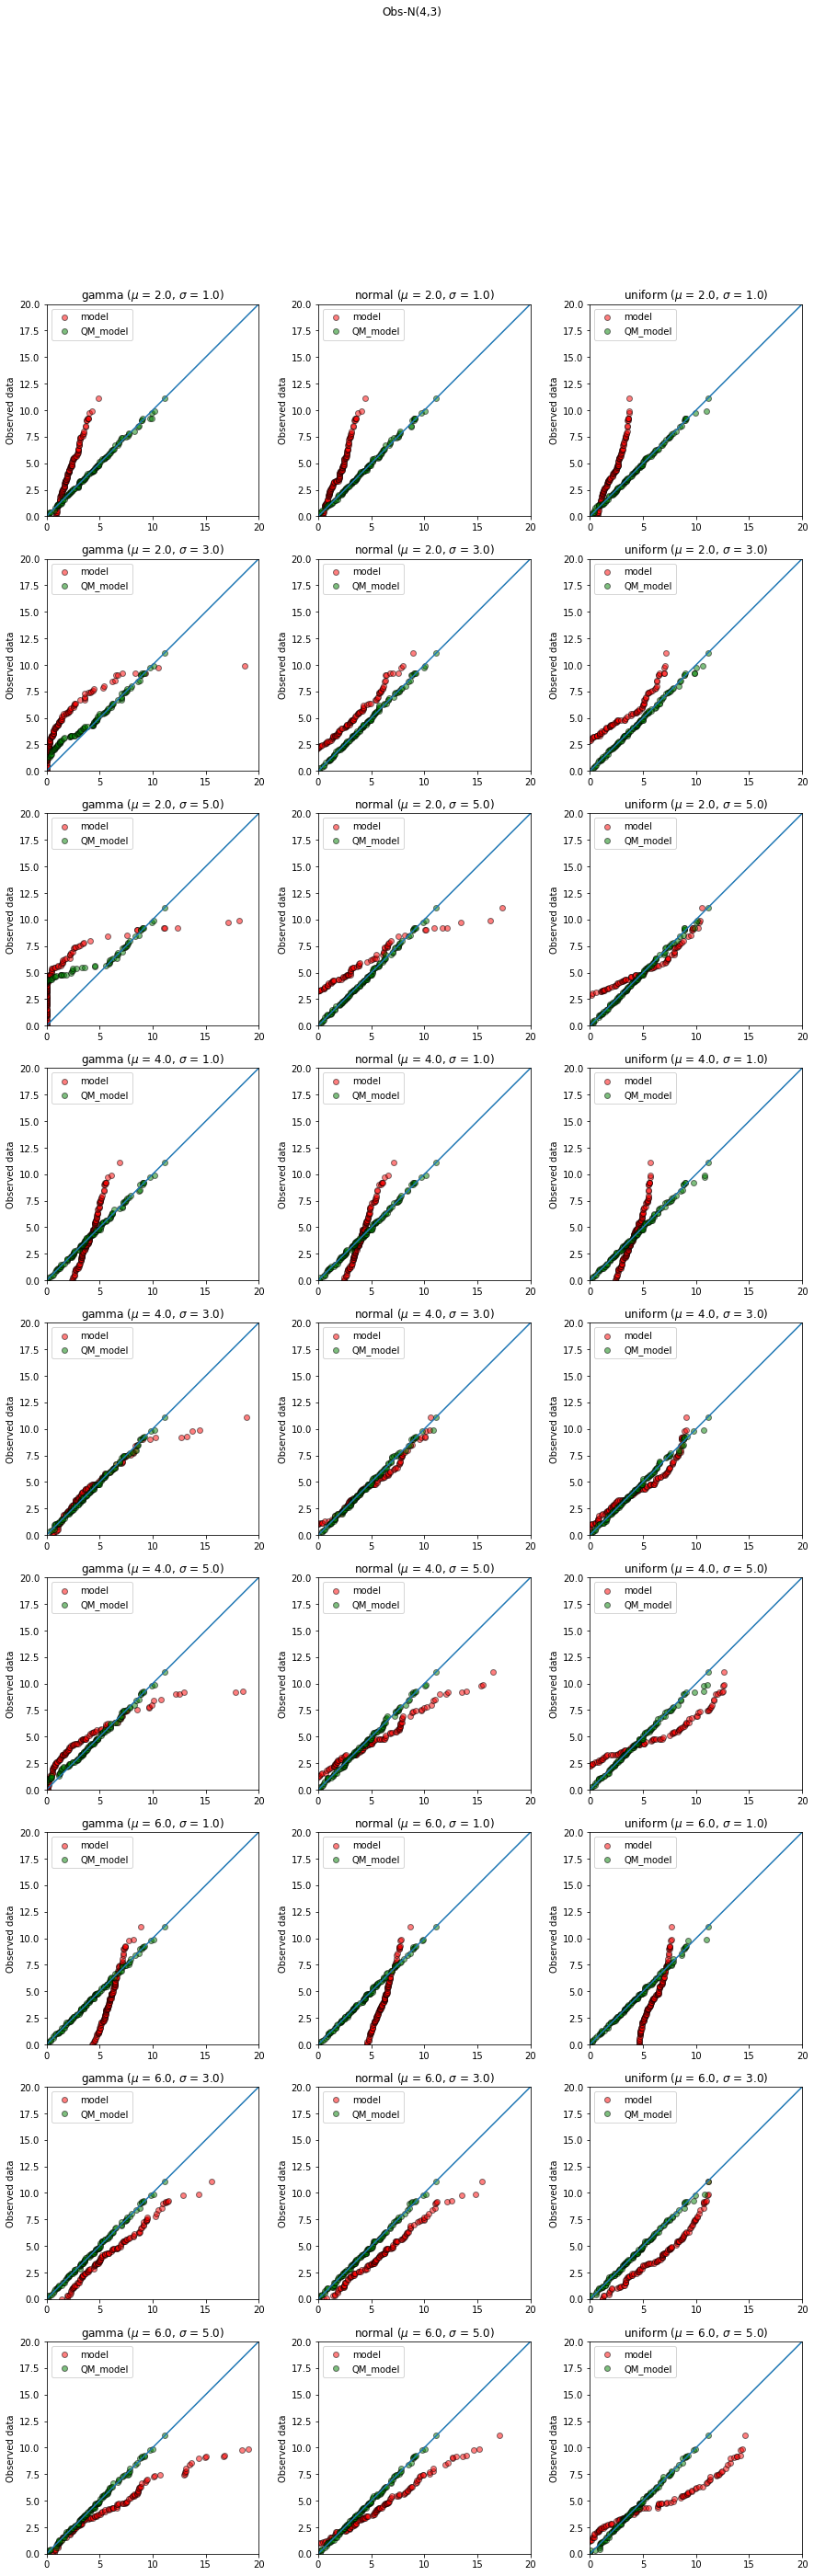

In [7]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model)/ncols))
print(nrows,ncols,len(data_model))
plt.figure(figsize=(15,45))
for itr,x in enumerate(data_model):
    
    ax=plt.subplot(nrows,ncols,itr+1)
    bc_x=bias_corr_historical_normal_np(data_obs_normal,x)
    
    qqplot(x,data_obs_normal, c='r', alpha=0.5, edgecolor='k',ax=ax)
    qqplot(bc_x,data_obs_normal,  c='g', alpha=0.5, edgecolor='k',ax=ax)

    plt.ylim([0,20])
    plt.xlim([0,20])
    # plt.xlabel('mm/day')
    plt.ylabel('Observed data')
    plt.legend(['model','QM_model'])
    plt.plot([0,60],[0,60])
    ax.set_aspect('equal')
    plt.title(dist[itr] + ' ($\mu$ = ' +str(mu_sigma[itr][0]) + ', $\sigma$ = ' +str(mu_sigma[itr][1])+')')
    
plt.suptitle('Obs-N(4,3)')
plt.show()

In [8]:
def prints(*arg):
    for ar in arg:
        print(ar.shape)

9 3 27


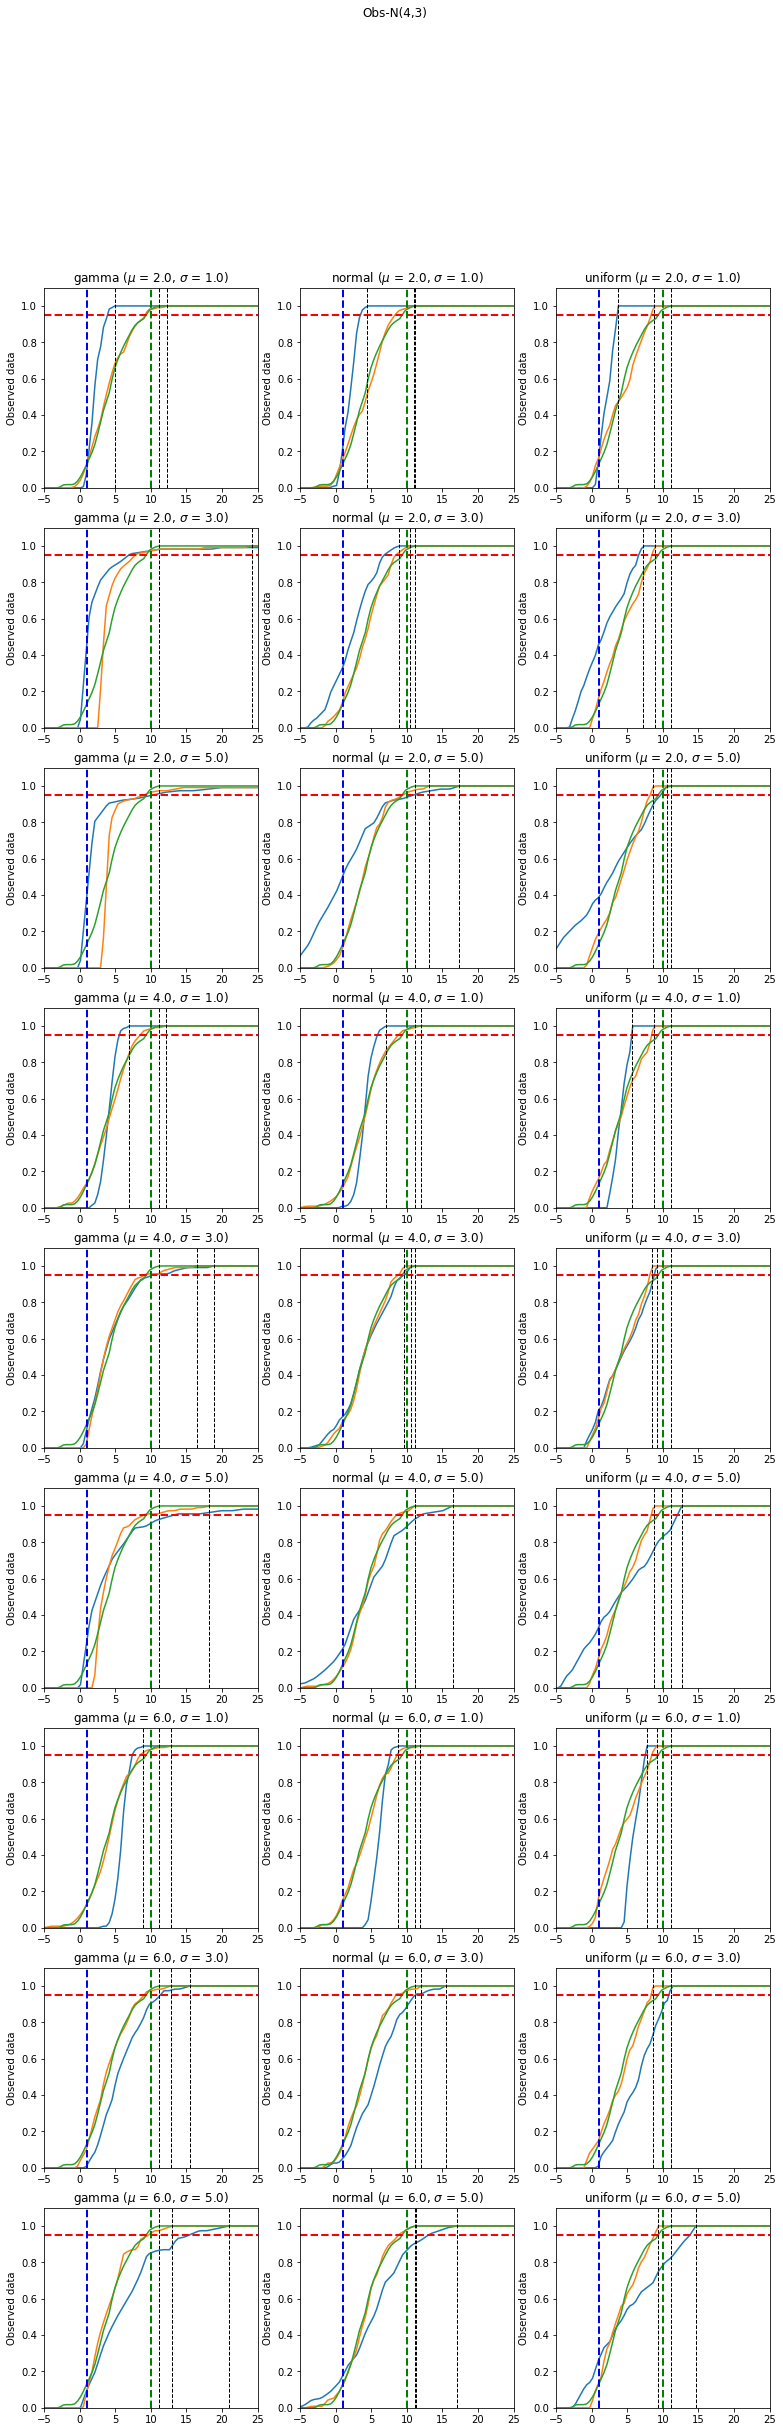

In [9]:
import scipy.stats
n_bins= 20 


ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model)/ncols))
print(nrows,ncols,len(data_model))
plt.figure(figsize=(13,39))
for itr,x in enumerate(data_model):
    
    ax=plt.subplot(nrows,ncols,itr+1)
    bc_x=bias_corr_historical_normal(data_obs_normal,x)
    bc_x[np.isinf(bc_x)] =  1000

    X = np.linspace(-10, 30.0, 100)
    
    hist = np.histogram(x, bins=n_bins)
    hist_dist = scipy.stats.rv_histogram(hist)
    plt.plot(X, hist_dist.cdf(X), label='model')

    hist = np.histogram(bc_x, bins=n_bins)
    hist_dist = scipy.stats.rv_histogram(hist)
    plt.plot(X, hist_dist.cdf(X), label='bc_model')

    hist = np.histogram(data_obs_normal, bins=n_bins)
    hist_dist = scipy.stats.rv_histogram(hist)
    plt.plot(X, hist_dist.cdf(X), label='obs')

    # plot_cdf(x,bc_x,data_obs_normal)
    plt.ylim([0,1.1])
    plt.xlim([-5,25])
    # plt.xlabel('mm/day')
    plt.ylabel('Observed data')
    # plt.plot([0,60],[0,60])
    # ax.set_aspect('equal')
    plt.title(dist[itr] + ' ($\mu$ = ' +str(mu_sigma[itr][0]) + ', $\sigma$ = ' +str(mu_sigma[itr][1])+')')
    
    plt.axhline(y=0.95, color = 'r',linewidth=2,linestyle= '--')
    plt.axvline(x=1, color = 'b',linewidth=2,linestyle= '--')
    plt.axvline(x=10, color = 'g',linewidth=2,linestyle= '--')
    
    
    plt.axvline(x=np.max(x), color = 'k',linewidth=1,linestyle= '--')
    plt.axvline(x=np.max(bc_x), color = 'k',linewidth=1,linestyle= '--')
    plt.axvline(x=np.max(data_obs_normal), color = 'k',linewidth=1,linestyle= '--')
    
    
    # plt.axhline(y=0.95)
    # plt.axhline(y=0.95)
    
    
    
plt.savefig('test.jpg',dpi=150)
plt.suptitle('Obs-N(4,3)')
plt.show()

9 3 27


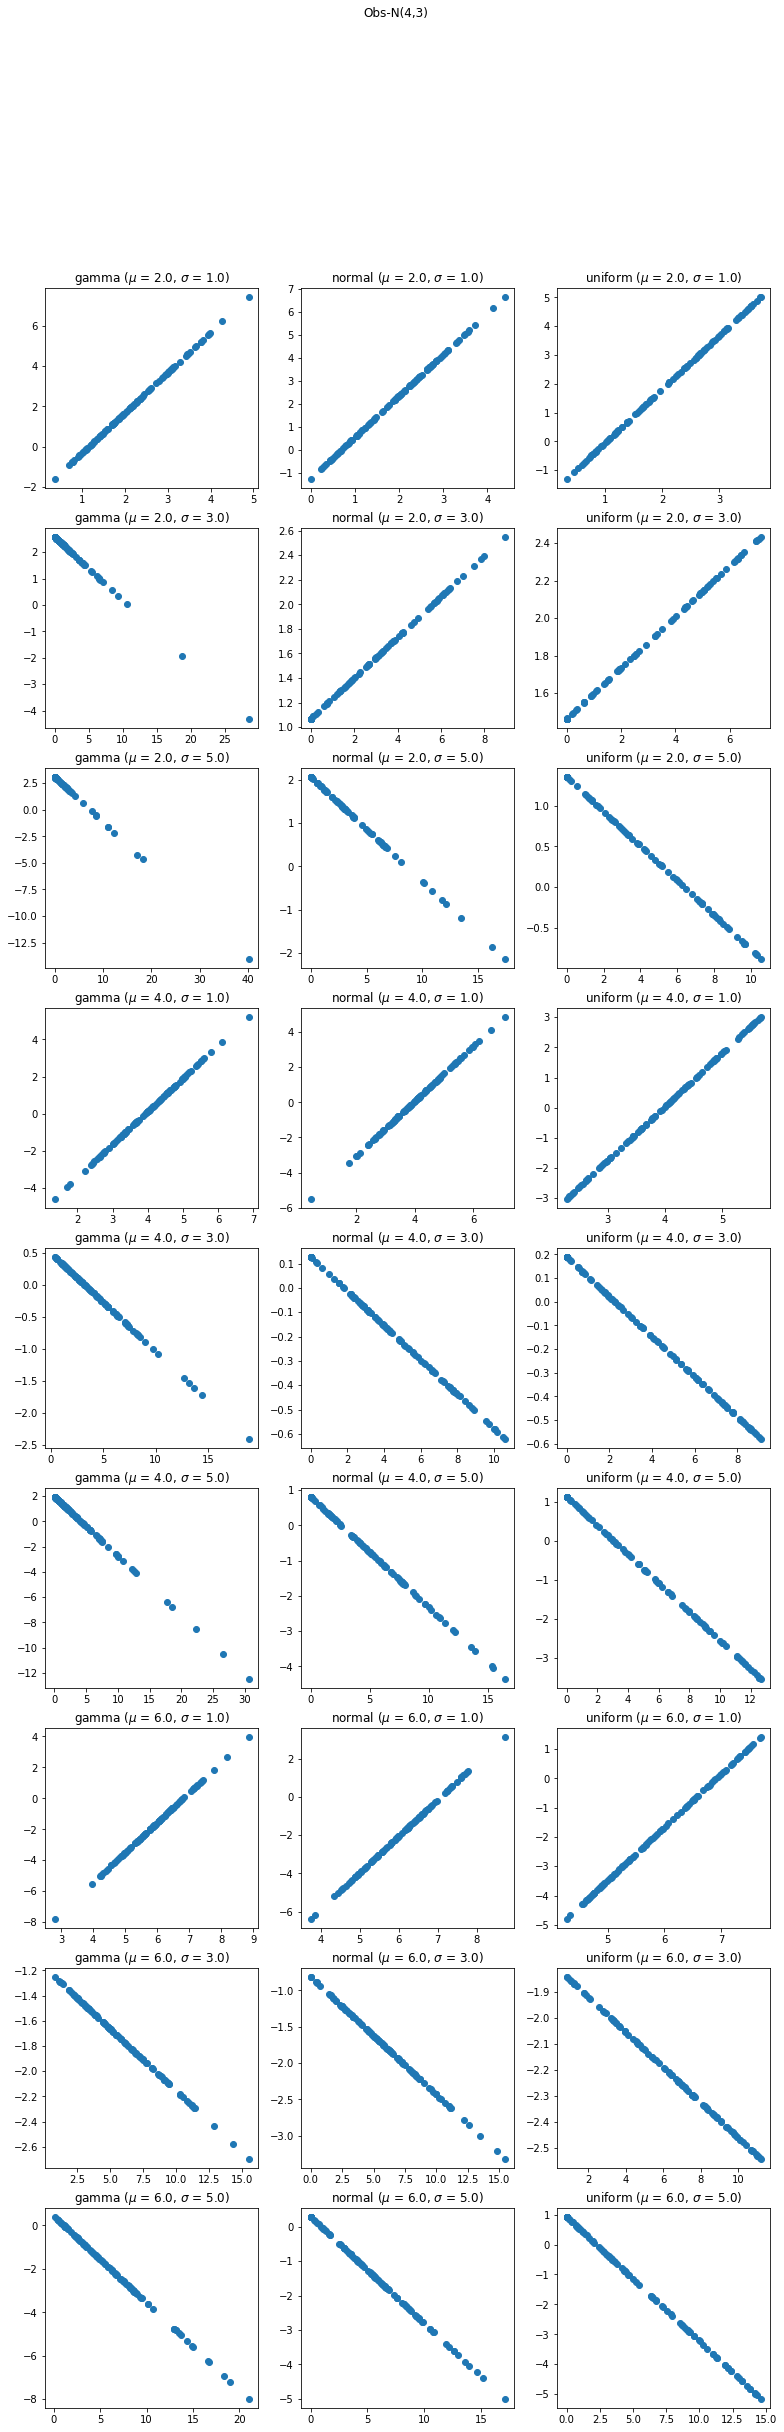

In [18]:
import scipy.stats
n_bins= 20 


ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model)/ncols))
print(nrows,ncols,len(data_model))
plt.figure(figsize=(13,39))
for itr,x in enumerate(data_model):
    
    ax=plt.subplot(nrows,ncols,itr+1)
    
    bc_x=bias_corr_historical_normal(data_obs_normal,x)
    
    bc_x[np.isinf(bc_x)] =  1000

    X = np.linspace(-10, 30.0, 100)
    corr =  bc_x - x
    plt.scatter(x, bc_x - x)
    # plt.scatter(data_obs_normal,corr)
    # plt.scatter(bc_x,corr)
    # plt.ylim([0,1.1])
    # plt.xlim([-5,25])
    # plt.xlabel('mm/day')
    # plt.ylabel('Observed data')
    plt.title(dist[itr] + ' ($\mu$ = ' +str(mu_sigma[itr][0]) + ', $\sigma$ = ' +str(mu_sigma[itr][1])+')')
    

    
#     plt.axvline(x=np.max(x), color = 'k',linewidth=1,linestyle= '--')
#     plt.axvline(x=np.max(bc_x), color = 'k',linewidth=1,linestyle= '--')
#     plt.axvline(x=np.max(data_obs_normal), color = 'k',linewidth=1,linestyle= '--')
    
    
    # plt.axhline(y=0.95)
    # plt.axhline(y=0.95)
    
    
    
# plt.savefig('test11.jpg',dpi=150)
plt.suptitle('Obs-N(4,3)')
plt.show()

In [10]:
def plot_cdf(x,bc_x,data_obs):
    n_bins= 20

    n, bins, patches=plt.hist(x,n_bins, alpha=0., density=True, histtype='stepfilled', cumulative=True,label='_Hidden')
    bins  = uu.box_to_cen(bins)
    bins = np.concatenate(([0,bins[0]],bins,[bins[-1],30]))
    n = np.concatenate(([0,0],n,[1,1]))
    plt.plot(bins,n, color='r', alpha=0.8)

    n, bins, patches=plt.hist(bc_x,n_bins, alpha=0., density=True, histtype='stepfilled', cumulative=True,label='_Hidden')
    bins  = uu.box_to_cen(bins)
    bins = np.concatenate(([0,bins[0]],bins,[bins[-1],30]))
    n = np.concatenate(([0,0],n,[1,1]))
    plt.plot(bins,n, color='g', alpha=0.8)


    n, bins, patches=plt.hist(data_obs,n_bins, alpha=0., density=True, histtype='stepfilled', cumulative=True,label='_Hidden',)
    bins  = uu.box_to_cen(bins)
    bins = np.concatenate(([0,bins[0]],bins,[bins[-1],30]))
    n = np.concatenate(([0,0],n,[1,1]))
    plt.plot(bins,n, color='k', alpha=0.8)
    plt.legend(['model','QM_model','Observation'])

    # n, bins, patches=plt.hist(bc_x,n_bins, alpha=0., density=True, histtype='stepfilled', cumulative=True,)
    # plt.plot(bins[:-1],n, color='g')

    # n, bins, patches=plt.hist(data_obs_normal,n_bins, color='k', alpha=0, density=True, histtype='stepfilled', cumulative=True,)
    # plt.plot(bins[:-1],n, color='k')



9 3 27


/tmp/ipykernel_1209846/3127579953.py:58: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/tmp/ipykernel_1209846/3127579953.py:59: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


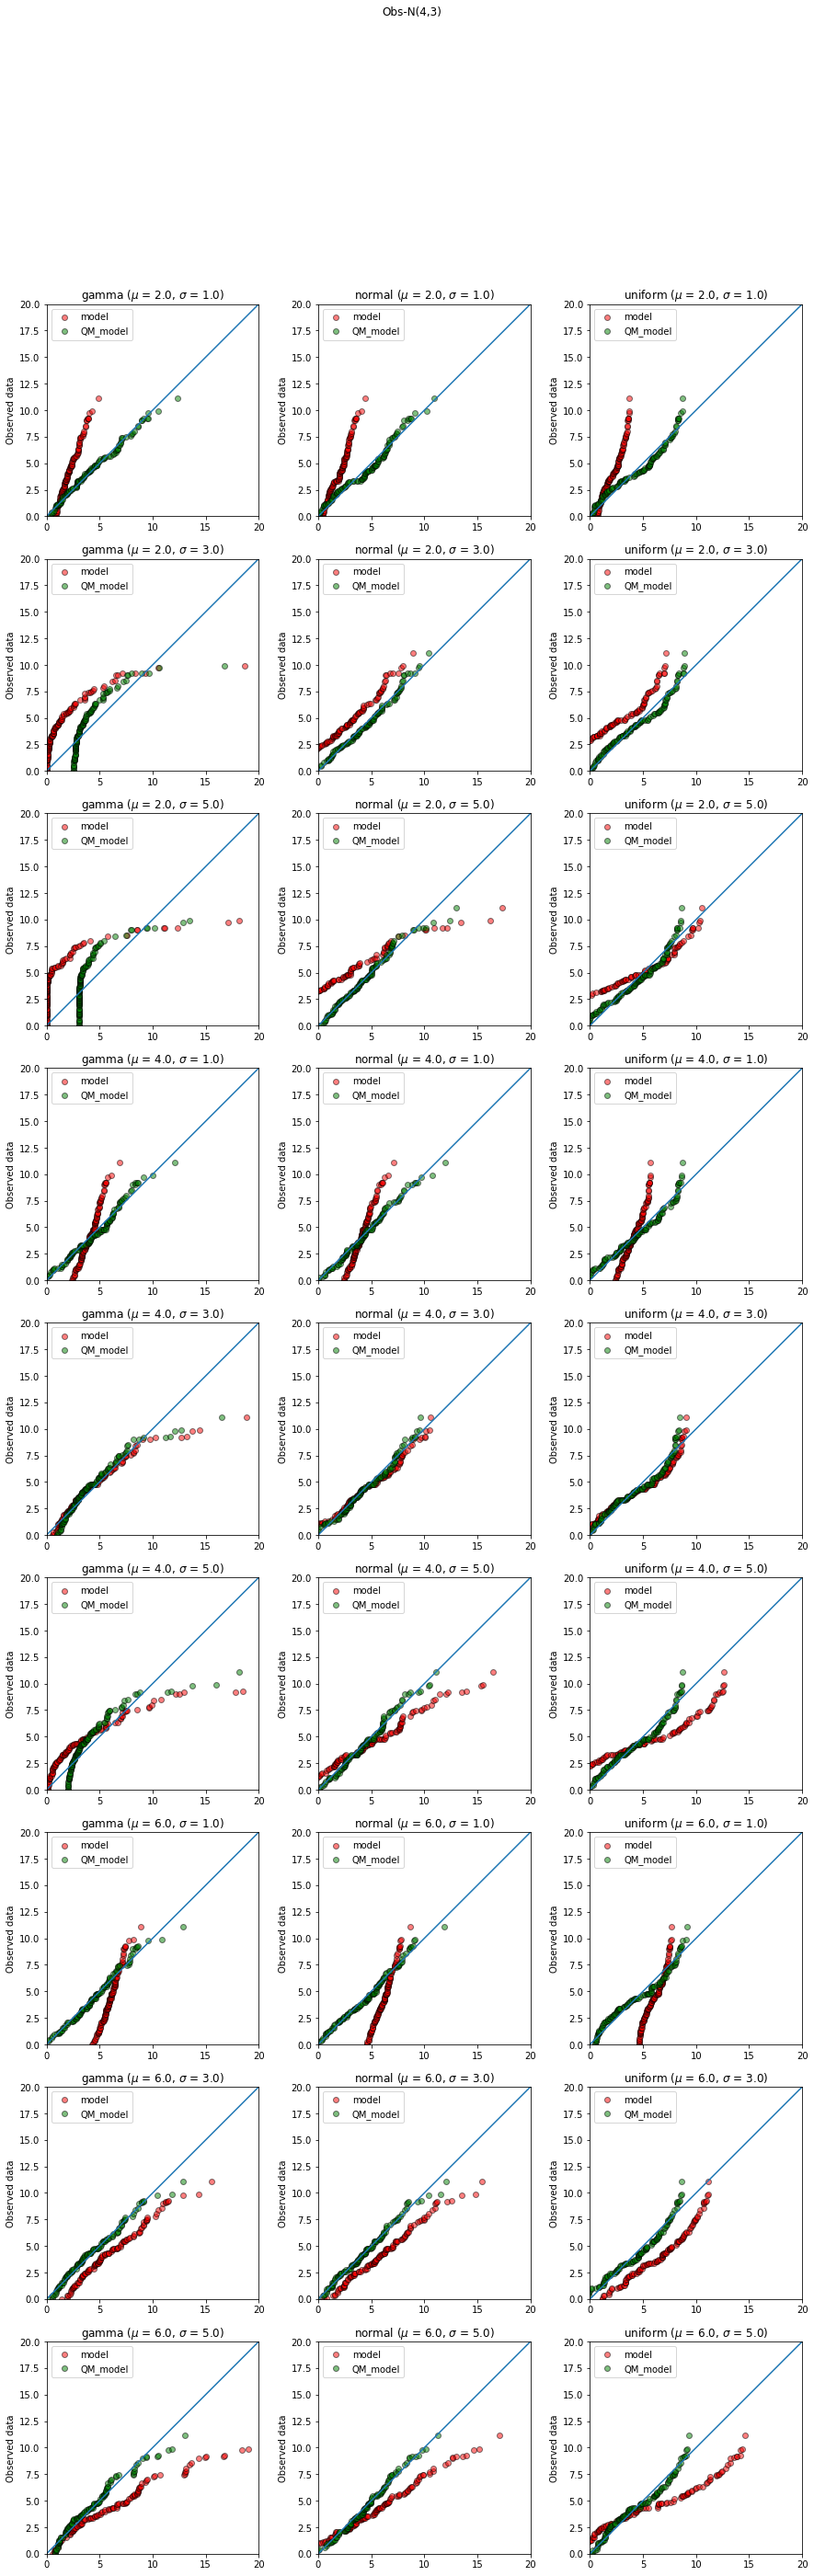

In [11]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model)/ncols))
print(nrows,ncols,len(data_model))
plt.figure(figsize=(15,45))
for itr,x in enumerate(data_model):
    
    ax=plt.subplot(nrows,ncols,itr+1)
    bc_x=bias_corr_historical_normal(data_obs_normal,x)
    
    qqplot(x,data_obs_normal, c='r', alpha=0.5, edgecolor='k',ax=ax)
    qqplot(bc_x,data_obs_normal,  c='g', alpha=0.5, edgecolor='k',ax=ax)

    plt.ylim([0,20])
    plt.xlim([0,20])
    # plt.xlabel('mm/day')
    plt.ylabel('Observed data')
    plt.legend(['model','QM_model'])
    plt.plot([0,60],[0,60])
    ax.set_aspect('equal')
    plt.title(dist[itr] + ' ($\mu$ = ' +str(mu_sigma[itr][0]) + ', $\sigma$ = ' +str(mu_sigma[itr][1])+')')
    
plt.suptitle('Obs-N(4,3)')
plt.show()

9 3 27


/tmp/ipykernel_1209846/3127579953.py:58: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/tmp/ipykernel_1209846/3127579953.py:59: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


Text(0.5, 0.98, 'Obs-N(4,3)')

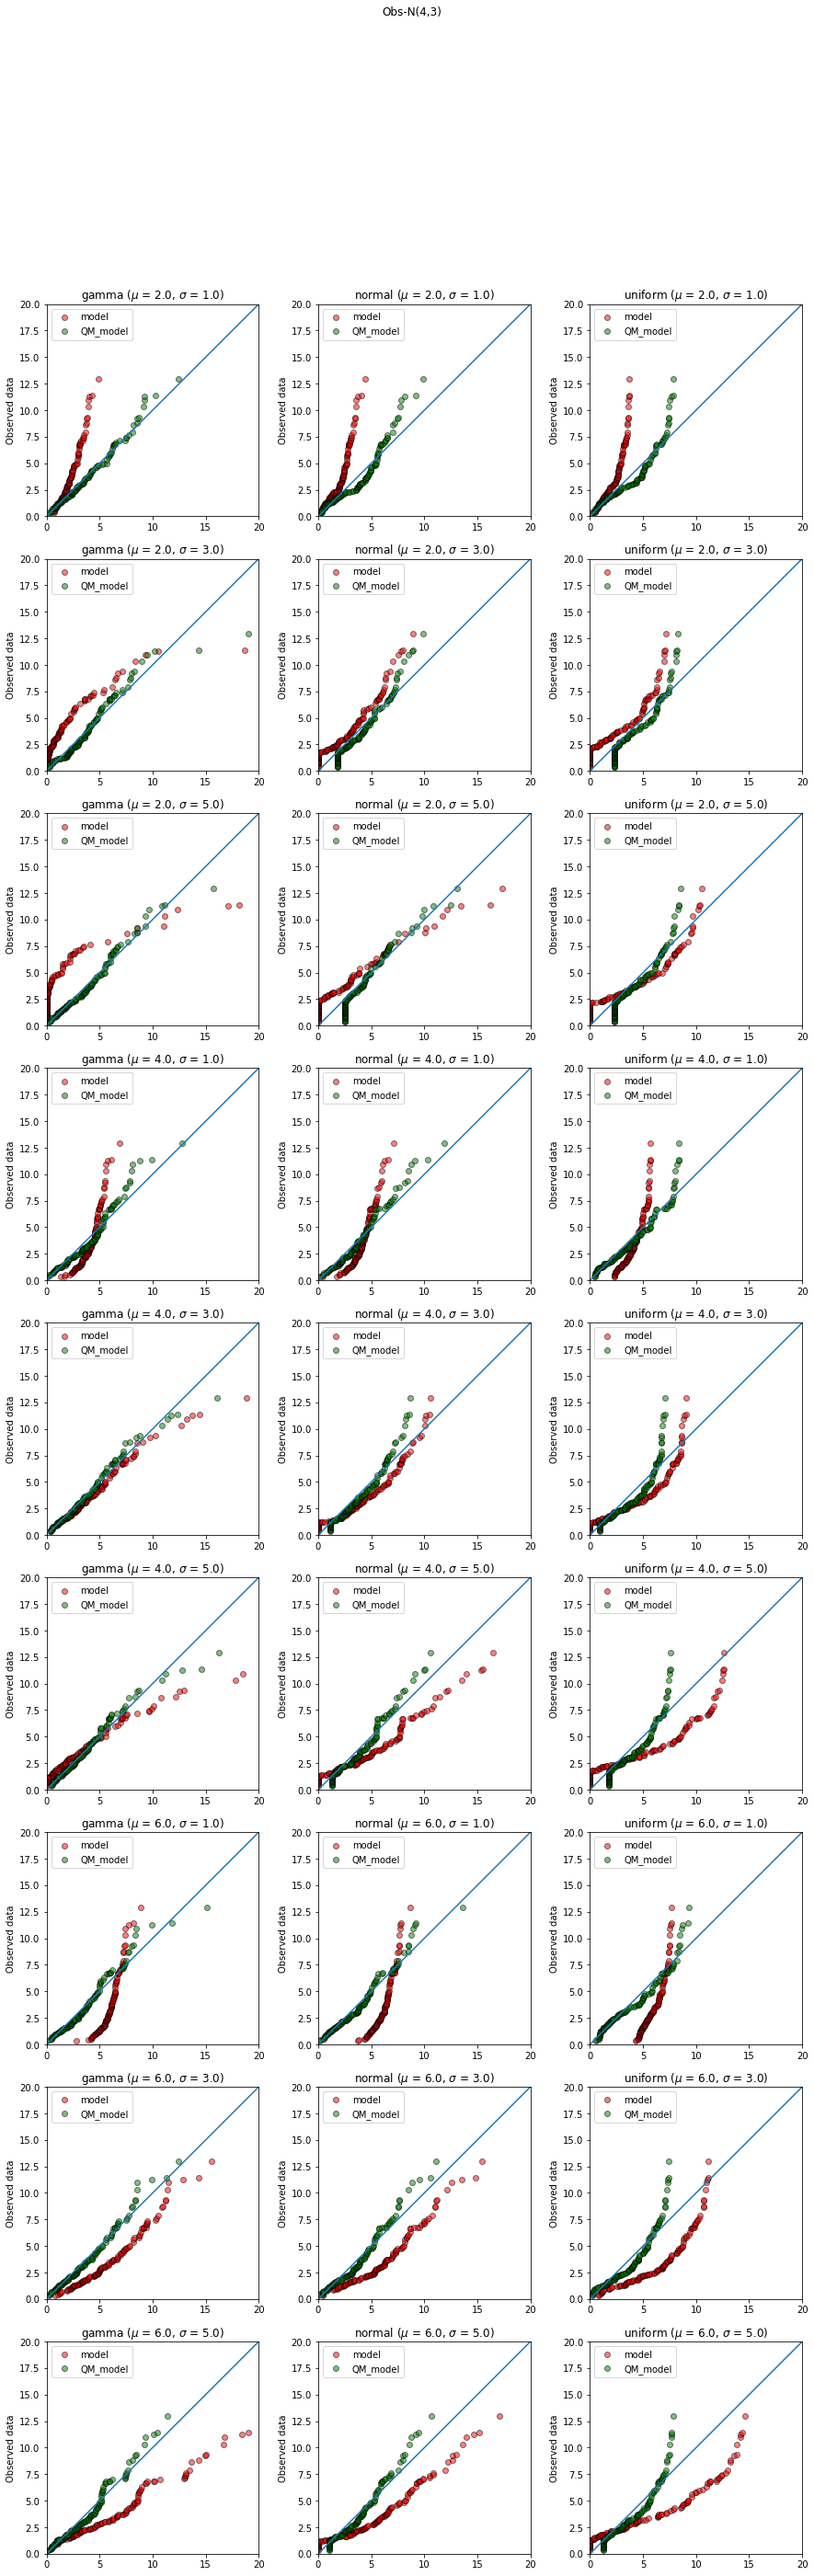

In [12]:

def bias_corr_historical_gamma_zeros(data_grid_obs,data_grid_hist):
    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[var_data_obs<0]=0
    var_data_hist[var_data_hist<0]=0

    var_data_obs[np.isnan(var_data_obs)]=0
    var_data_hist[np.isnan(var_data_hist)]=0

    bias_corr=np.zeros(var_data_hist.shape[0]);

    data=var_data_hist
    data_non_zeros=(data[data!=0])
    count_zeros=(data[data==0].shape[0])
    count_total=(data.shape[0])
    p_zeros=count_zeros/count_total
    fita,fitloc,fitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)
#     print('Mod:',fita,fitloc,fitscale)
    cdf= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(var_data_hist, a=fita,loc=fitloc,scale=fitscale)
    data=var_data_obs
    data_non_zeros=(data[data!=0])
    count_zeros=(data[data==0].shape[0])
    count_total=(data.shape[0])
    p_zeros_imd=count_zeros/count_total
    ofita,ofitloc,ofitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)
#     print('Obs:',ofita,ofitloc,ofitscale)

#     print(p_zeros,p_zeros_imd)
    for iter in range(cdf.shape[0]):
        cdfi=cdf[iter]
        if cdfi<=p_zeros_imd:
            bias_corr[iter]=0
        else:
            z=(cdfi-p_zeros_imd)/(1-p_zeros_imd)
            bias_corr[iter]=scipy.stats.gamma.ppf(z, a=ofita,loc=ofitloc,scale=ofitscale)

    return bias_corr



ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model)/ncols))
print(nrows,ncols,len(data_model))
plt.figure(figsize=(15,45))
for itr,x in enumerate(data_model):
    
    ax=plt.subplot(nrows,ncols,itr+1)
    bc_x=bias_corr_historical_gamma_zeros(data_obs_gamma,x)
    
    qqplot(x,data_obs_gamma, c='r', alpha=0.5, edgecolor='k',ax=ax)
    qqplot(bc_x,data_obs_gamma,  c='g', alpha=0.5, edgecolor='k',ax=ax)

    plt.ylim([0,20])
    plt.xlim([0,20])
    # plt.xlabel('mm/day')
    plt.ylabel('Observed data')
    plt.legend(['model','QM_model'])
    plt.plot([0,60],[0,60])
    ax.set_aspect('equal')
    plt.title(dist[itr] + ' ($\mu$ = ' +str(mu_sigma[itr][0]) + ', $\sigma$ = ' +str(mu_sigma[itr][1])+')')
    
plt.suptitle('Obs-N(4,3)')


9 3 27


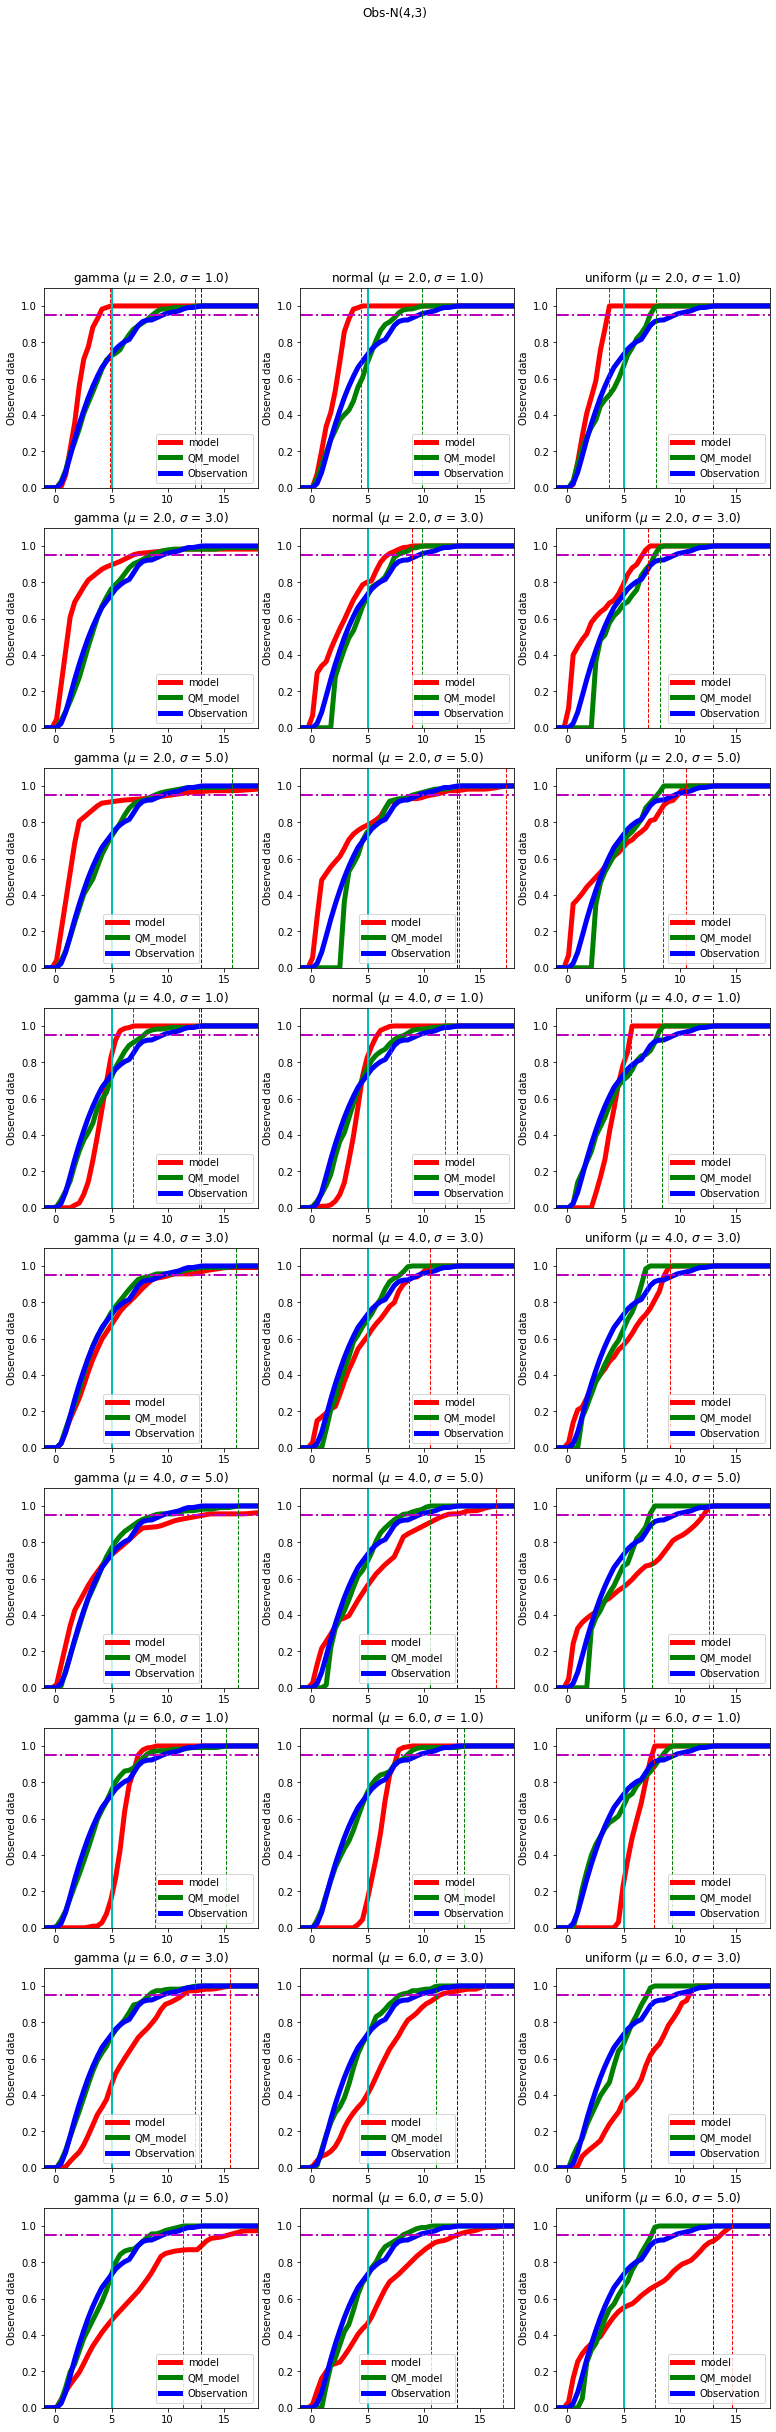

In [13]:
import scipy.stats
n_bins= 20 


ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model)/ncols))
print(nrows,ncols,len(data_model))
plt.figure(figsize=(13,39))
for itr,x in enumerate(data_model):
    
    ax=plt.subplot(nrows,ncols,itr+1)
    bc_x=bias_corr_historical_gamma_zeros(data_obs_gamma,x)
    bc_x[np.isinf(bc_x)] =  1000

    X = np.linspace(-10, 30.0, 100)
    
    hist = np.histogram(x, bins=n_bins)
    hist_dist = scipy.stats.rv_histogram(hist)
    plt.plot(X, hist_dist.cdf(X), label='model',color='r',linewidth=5,)

    hist = np.histogram(bc_x, bins=n_bins)
    hist_dist = scipy.stats.rv_histogram(hist)
    plt.plot(X, hist_dist.cdf(X), label='bc_model',color='g',linewidth=5,)

    hist = np.histogram(data_obs_gamma, bins=n_bins)
    hist_dist = scipy.stats.rv_histogram(hist)
    plt.plot(X, hist_dist.cdf(X), label='obs',color='b',linewidth=5,)
    plt.legend(['model','QM_model','Observation'])

    # plot_cdf(x,bc_x,data_obs_normal)
    plt.ylim([0,1.1])
    plt.xlim([-1,18])
    # plt.xlabel('mm/day')
    plt.ylabel('Observed data')
    # plt.plot([0,60],[0,60])
    # ax.set_aspect('equal')
    plt.title(dist[itr] + ' ($\mu$ = ' +str(mu_sigma[itr][0]) + ', $\sigma$ = ' +str(mu_sigma[itr][1])+')')
    
    plt.axhline(y=0.95, color = 'm',linewidth=2,linestyle= '-.')
    # plt.axvline(x=1, color = 'b',linewidth=2,linestyle= '--')
    plt.axvline(x=5, color = 'c',linewidth=2,linestyle= '-')
    
    
    plt.axvline(x=np.max(x), color = 'r',linewidth=1,linestyle= '--')
    plt.axvline(x=np.max(bc_x), color = 'g',linewidth=1,linestyle= '--')
    plt.axvline(x=np.max(data_obs_gamma), color = 'b',linewidth=1,linestyle= '--')
    
    # plt.axhline(y=0.95)
    # plt.axhline(y=0.95)
    
    
    
plt.savefig('test.jpg',dpi=150)
plt.savefig('test.svg')
plt.suptitle('Obs-N(4,3)')
plt.show()

In [ ]:
# 

## Indices

In [97]:

sizeN=500
data_model=[]
data_model_sep['gamma']=[]
data_model_sep['uniform']=[]
data_model_sep['normal']=[]


mu_sigma_sep=[]
dist=[]
for mu in np.arange(2,6.1,1):
    for sigma in np.arange(1,5.1,1):
        theta = sigma *sigma / mu
        k= mu/theta
        data_gamma = scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=sizeN)
        
        data_normal = scipy.stats.norm.rvs(loc=mu,scale=sigma, size=sizeN)
        loc = mu - np.sqrt(3) * sigma
        scale = 2 * np.sqrt(3) * sigma 
        data_uniform = scipy.stats.uniform.rvs(loc=loc,scale=scale, size=sizeN)
        mu_sigma_sep.append([mu,sigma])
        dist.append('gamma')
        data_model_sep['gamma'].append(data_gamma)
        dist.append('normal')
        data_model_sep['normal'].append(data_normal)
        dist.append('uniform')
        data_model_sep['uniform'].append(data_uniform)
        
## observation

In [98]:
import syn as syn
import utility_module_2_v_3 as uu

In [99]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model_sep['gamma'])/ncols))

# plt.figure(figsize=(15,45))
indices_obs ={}
indices_mod ={}
indices_mbc ={}
for name,func in zip(['CDD','R10mm','R95p','Rx5day'],[syn.CDD,syn.R10mm,syn.R95p,syn.Rx5day]):
    indices_obs[name]=[]
    indices_mod[name]=[]
    indices_mbc[name]=[]
    for itr,x in enumerate(data_model_sep['gamma']):

        bc_x = bias_corr_historical_gamma_zeros(data_obs_gamma,x)

        indices_mbc[name].append(func(bc_x))
        indices_mod[name].append(func(x))
        indices_obs[name].append(func(data_obs_gamma))
    

[9.79385666]
[4.0505987]
[10.22962871]
[9.8886329]
[7.20256981]
[10.22962871]
[9.71054729]
[10.33541201]
[10.22962871]
[10.08882955]
[14.34915026]
[10.22962871]
[9.88593673]
[19.3321599]
[10.22962871]
[9.81057108]
[5.01812671]
[10.22962871]
[9.88769407]
[7.93751865]
[10.22962871]
[9.77243508]
[9.84983267]
[10.22962871]
[9.86871388]
[13.21118052]
[10.22962871]
[9.77849068]
[17.24519541]
[10.22962871]
[9.69339225]
[5.84969671]
[10.22962871]
[9.6743953]
[8.43353323]
[10.22962871]
[10.03020329]
[10.07124393]
[10.22962871]
[9.64160244]
[12.60214559]
[10.22962871]
[9.97763662]
[17.14949317]
[10.22962871]
[9.68669253]
[6.80451854]
[10.22962871]
[9.8493982]
[8.99158539]
[10.22962871]
[9.84679605]
[11.46382621]
[10.22962871]
[9.85871925]
[13.57227029]
[10.22962871]
[9.89415533]
[16.2075655]
[10.22962871]
[9.75816314]
[7.84006872]
[10.22962871]
[10.06517044]
[9.94758693]
[10.22962871]
[9.76200933]
[11.77384638]
[10.22962871]
[9.62990328]
[13.4986642]
[10.22962871]
[9.72239045]
[16.35149685]
[10.

(6,)


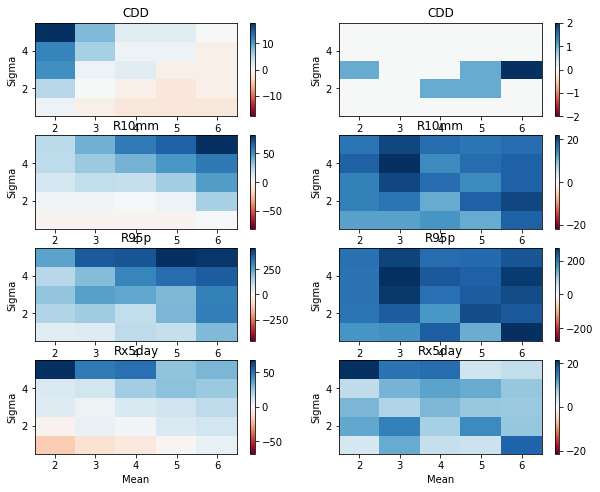

In [100]:
name='Rx5day'
plt.figure(figsize=(10,10))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)

for itr,ind_name in enumerate(['CDD','R10mm','R95p','Rx5day']):
    
    plt.subplot(5,2,itr*2 +1 )
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod-ind_obs)))
    plt.pcolor(xx,yy,ind_mod-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    
    plt.subplot(5,2,itr*2 +2 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc-ind_obs)))
    plt.pcolor(xx,yy,ind_mbc-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)


(6,)


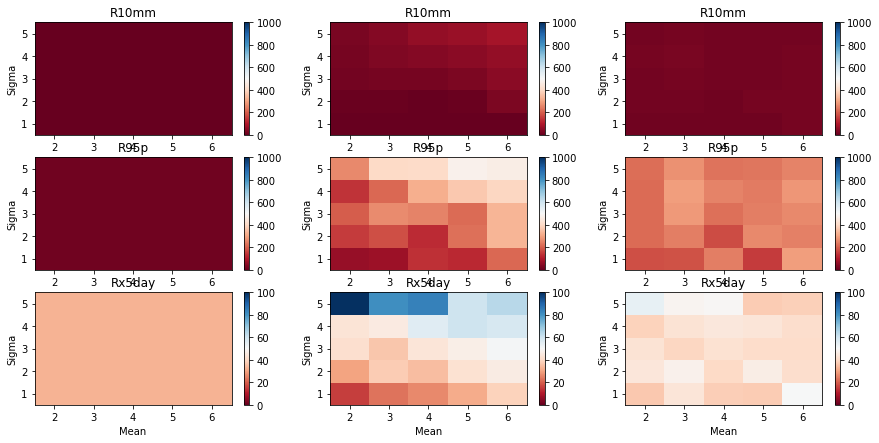

In [101]:
plt.figure(figsize=(15,12))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)
lim={}
lim['R10mm'] = 1000
lim['R95p'] = 1000
lim['Rx5day']=100
for itr,ind_name in enumerate(['R10mm','R95p','Rx5day']):
    
    plt.subplot(5,3,itr*3 +1 )
    
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_obs)))
    plt.pcolor(xx,yy,ind_obs,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])

    
    plt.subplot(5,3,itr*3 +2 )
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod)))
    plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.clim([0,lim[ind_name]])
    plt.title(ind_name)
    
    
    plt.subplot(5,3,itr*3 +3 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc)))
    plt.pcolor(xx,yy,ind_mbc,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])
    


In [102]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model_sep['gamma'])/ncols))

# plt.figure(figsize=(15,45))
indices_obs ={}
indices_mod ={}
indices_mbc ={}
for name,func in zip(['CDD','R10mm','R95p','Rx5day'],[syn.CDD,syn.R10mm,syn.R95p,syn.Rx5day]):
    indices_obs[name]=[]
    indices_mod[name]=[]
    indices_mbc[name]=[]
    for itr,x in enumerate(data_model_sep['normal']):

        bc_x = bias_corr_historical_gamma_zeros(data_obs_gamma,x)

        indices_mbc[name].append(func(bc_x))
        indices_mod[name].append(func(x))
        indices_obs[name].append(func(data_obs_gamma))
    

[8.9632876]
[4.0672836]
[10.22962871]
[8.87158648]
[6.25985962]
[10.22962871]
[8.46615722]
[8.40677701]
[10.22962871]
[8.12668841]
[10.44971542]
[10.22962871]
[8.33134023]
[12.14227701]
[10.22962871]
[9.27741746]
[5.10604049]
[10.22962871]
[9.37210608]
[7.39694676]
[10.22962871]
[9.01646401]
[8.91439734]
[10.22962871]
[8.66557529]
[11.99564754]
[10.22962871]
[8.30756967]
[13.65291014]
[10.22962871]
[9.58861491]
[6.05092584]
[10.22962871]
[9.4115218]
[8.3516766]
[10.22962871]
[10.66685348]
[10.20211694]
[10.22962871]
[9.0389292]
[12.39418552]
[10.22962871]
[8.91391629]
[14.69939027]
[10.22962871]
[9.80690017]
[6.85942098]
[10.22962871]
[8.96854578]
[9.55809734]
[10.22962871]
[9.48895877]
[11.45229191]
[10.22962871]
[9.41466017]
[13.69378571]
[10.22962871]
[9.2444633]
[15.20536552]
[10.22962871]
[9.73671201]
[7.91346253]
[10.22962871]
[8.79618]
[10.07115084]
[10.22962871]
[9.27764987]
[12.88554126]
[10.22962871]
[9.16013648]
[14.69265414]
[10.22962871]
[9.13761554]
[16.70351976]
[10.2296

(6,)


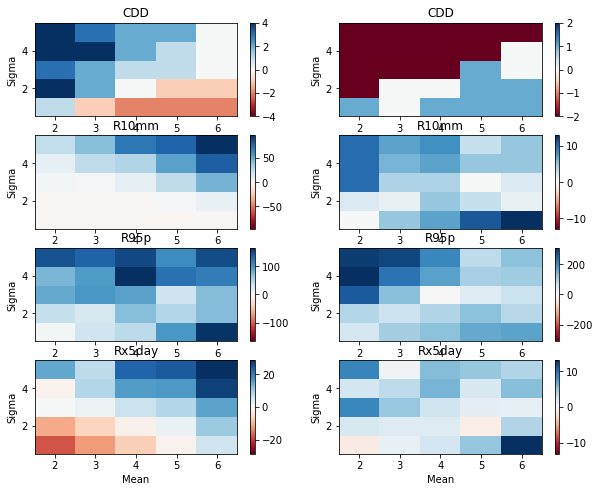

In [103]:
name='Rx5day'
plt.figure(figsize=(10,10))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)

for itr,ind_name in enumerate(['CDD','R10mm','R95p','Rx5day']):
    
    plt.subplot(5,2,itr*2 +1 )
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod-ind_obs)))
    plt.pcolor(xx,yy,ind_mod-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    
    plt.subplot(5,2,itr*2 +2 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc-ind_obs)))
    plt.pcolor(xx,yy,ind_mbc-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)


(6,)


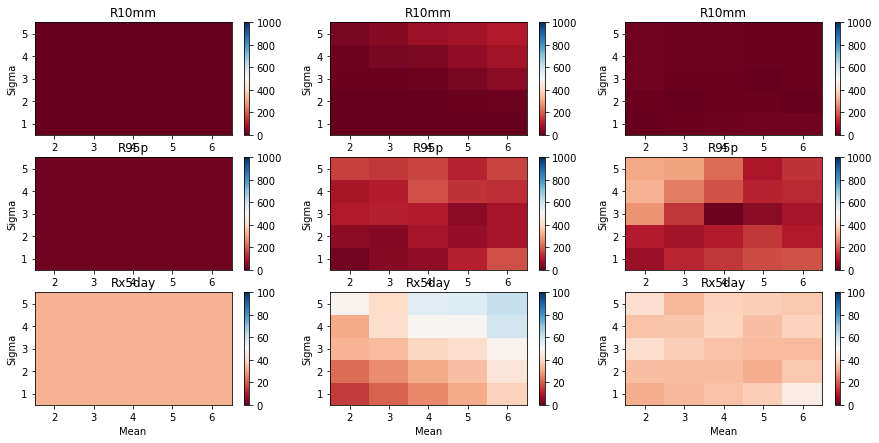

In [104]:
plt.figure(figsize=(15,12))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)
lim={}
lim['R10mm'] = 1000
lim['R95p'] = 1000
lim['Rx5day']=100
for itr,ind_name in enumerate(['R10mm','R95p','Rx5day']):
    
    plt.subplot(5,3,itr*3 +1 )
    
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_obs)))
    plt.pcolor(xx,yy,ind_obs,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])

    
    plt.subplot(5,3,itr*3 +2 )
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod)))
    plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.clim([0,lim[ind_name]])
    plt.title(ind_name)
    
    
    plt.subplot(5,3,itr*3 +3 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc)))
    plt.pcolor(xx,yy,ind_mbc,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])
    


In [105]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model_sep['gamma'])/ncols))

# plt.figure(figsize=(15,45))
indices_obs ={}
indices_mod ={}
indices_mbc ={}
for name,func in zip(['CDD','R10mm','R95p','Rx5day'],[syn.CDD,syn.R10mm,syn.R95p,syn.Rx5day]):
    indices_obs[name]=[]
    indices_mod[name]=[]
    indices_mbc[name]=[]
    for itr,x in enumerate(data_model_sep['uniform']):

        bc_x = bias_corr_historical_gamma_zeros(data_obs_gamma,x)

        indices_mbc[name].append(func(bc_x))
        indices_mod[name].append(func(x))
        indices_obs[name].append(func(data_obs_gamma))
    

[9.59522507]
[4.30519411]
[10.22962871]
[8.52857082]
[6.20687425]
[10.22962871]
[8.21085638]
[8.91879581]
[10.22962871]
[8.02026878]
[10.66573522]
[10.22962871]
[8.16935708]
[12.60642682]
[10.22962871]
[10.23116396]
[5.32617836]
[10.22962871]
[9.59982064]
[7.76357463]
[10.22962871]
[8.62527026]
[10.27204952]
[10.22962871]
[8.06480994]
[11.4103474]
[10.22962871]
[8.12516673]
[13.479526]
[10.22962871]
[10.31244637]
[5.98600918]
[10.22962871]
[9.81799379]
[8.89249706]
[10.22962871]
[9.29552476]
[11.30771482]
[10.22962871]
[8.64077821]
[12.90517996]
[10.22962871]
[8.54349399]
[15.43647808]
[10.22962871]
[10.07869517]
[6.81414536]
[10.22962871]
[10.26728614]
[9.27873409]
[10.22962871]
[9.15484735]
[12.1212832]
[10.22962871]
[8.95025832]
[14.5053049]
[10.22962871]
[8.61388973]
[17.07644711]
[10.22962871]
[10.33957471]
[7.76022907]
[10.22962871]
[10.2014223]
[9.64498419]
[10.22962871]
[9.66178859]
[13.68184541]
[10.22962871]
[9.49718976]
[15.45558029]
[10.22962871]
[9.30494671]
[17.12883826]


(6,)


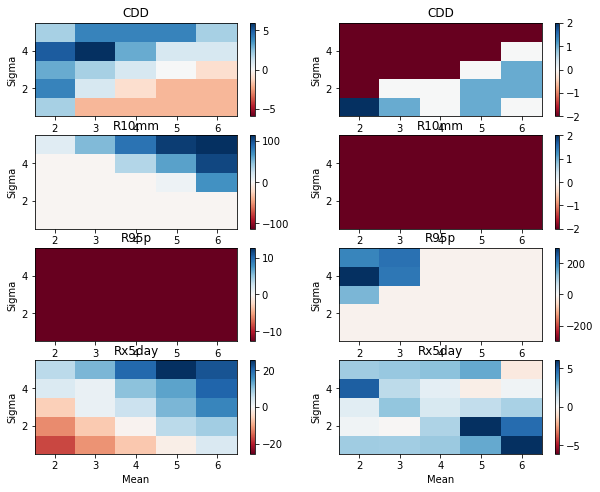

In [106]:
name='Rx5day'
plt.figure(figsize=(10,10))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)

for itr,ind_name in enumerate(['CDD','R10mm','R95p','Rx5day']):
    
    plt.subplot(5,2,itr*2 +1 )
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod-ind_obs)))
    plt.pcolor(xx,yy,ind_mod-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    
    plt.subplot(5,2,itr*2 +2 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc-ind_obs)))
    plt.pcolor(xx,yy,ind_mbc-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)


(6,)


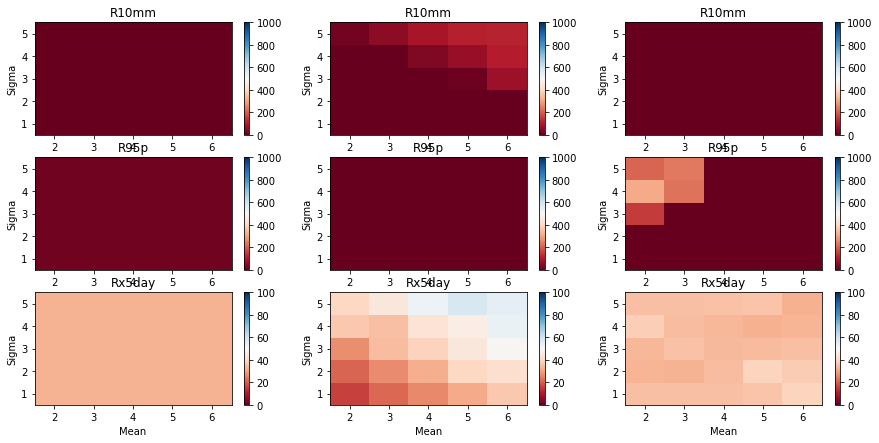

In [107]:
plt.figure(figsize=(15,12))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)
lim={}
lim['R10mm'] = 1000
lim['R95p'] = 1000
lim['Rx5day']=100
for itr,ind_name in enumerate(['R10mm','R95p','Rx5day']):
    
    plt.subplot(5,3,itr*3 +1 )
    
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_obs)))
    plt.pcolor(xx,yy,ind_obs,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])

    
    plt.subplot(5,3,itr*3 +2 )
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod)))
    plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.clim([0,lim[ind_name]])
    plt.title(ind_name)
    
    
    plt.subplot(5,3,itr*3 +3 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc)))
    plt.pcolor(xx,yy,ind_mbc,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])
    


# normal 

In [79]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model_sep['gamma'])/ncols))

# plt.figure(figsize=(15,45))
indices_obs ={}
indices_mod ={}
indices_mbc ={}
for name,func in zip(['CDD','R10mm','R95p','Rx5day'],[syn.CDD,syn.R10mm,syn.R95p,syn.Rx5day]):
    indices_obs[name]=[]
    indices_mod[name]=[]
    indices_mbc[name]=[]
    for itr,x in enumerate(data_model_sep['gamma']):

        bc_x = bias_corr_historical_normal_np(data_obs_normal,x)
#         print(func)
        try:
            indices_mbc[name].append(func(bc_x))
        except:
            bc_x[np.isinf(bc_x)]=np.nan
            indices_mbc[name].append(func(bc_x))
        indices_mod[name].append(func(x))
        indices_obs[name].append(func(data_obs_normal))
    

[9.81642071]
[4.13965784]
[9.64176585]
[9.80291778]
[8.08069055]
[9.64176585]
[10.35920085]
[10.33659142]
[9.64176585]
[11.45010841]
[14.81974757]
[9.64176585]
[12.11520882]
[21.6867724]
[9.64176585]
[9.7146817]
[5.09461437]
[9.64176585]
[9.72076523]
[7.22079904]
[9.64176585]
[9.67886912]
[10.35535824]
[9.64176585]
[9.87770066]
[12.79904497]
[9.64176585]
[11.69109914]
[18.93265786]
[9.64176585]
[9.76051239]
[5.75389883]
[9.64176585]
[9.71029751]
[7.88711876]
[9.64176585]
[9.7263596]
[10.07175215]
[9.64176585]
[9.89807333]
[12.90907191]
[9.64176585]
[10.09181039]
[15.65628157]
[9.64176585]
[9.74482218]
[6.84876402]
[9.64176585]
[9.82138189]
[8.99450007]
[9.64176585]
[9.85143942]
[11.67047989]
[9.64176585]
[9.63527469]
[14.43285845]
[9.64176585]
[9.81543455]
[14.97280147]
[9.64176585]
[9.74187713]
[7.55246533]
[9.64176585]
[9.68773188]
[9.92653305]
[9.64176585]
[9.74922979]
[12.33677187]
[9.64176585]
[9.70893063]
[14.84060354]
[9.64176585]
[9.76357696]
[17.20632196]
[9.64176585]


(6,)


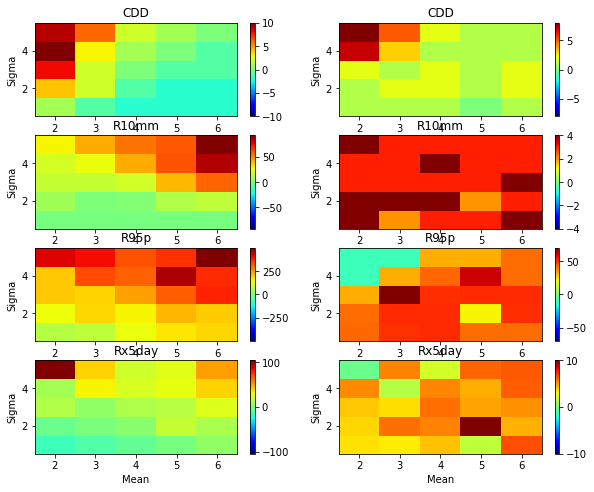

In [80]:
name='Rx5day'
plt.figure(figsize=(10,10))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)

for itr,ind_name in enumerate(['CDD','R10mm','R95p','Rx5day']):
    
    plt.subplot(5,2,itr*2 +1 )
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod-ind_obs)))
    plt.pcolor(xx,yy,ind_mod-ind_obs,vmin=-vmm,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    
    plt.subplot(5,2,itr*2 +2 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc-ind_obs)))
    plt.pcolor(xx,yy,ind_mbc-ind_obs,vmin=-vmm,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)


(6,)


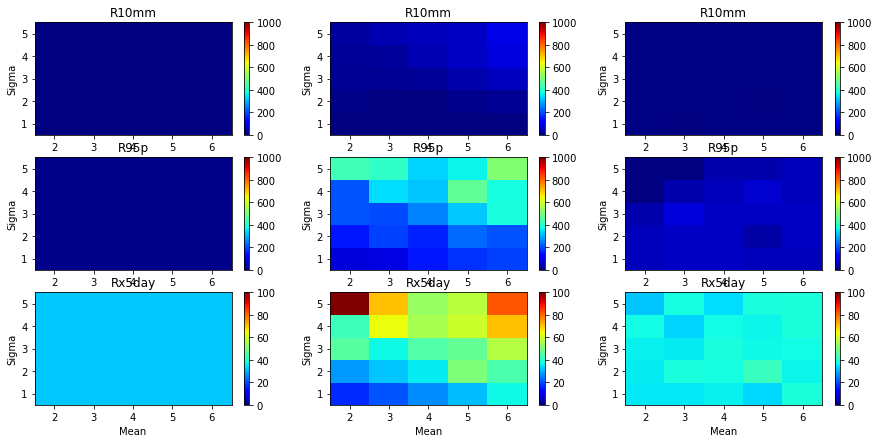

In [81]:
plt.figure(figsize=(15,12))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)
lim={}
lim['R10mm'] = 1000
lim['R95p'] = 1000
lim['Rx5day']=100
for itr,ind_name in enumerate(['R10mm','R95p','Rx5day']):
    
    plt.subplot(5,3,itr*3 +1 )
    
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_obs)))
    plt.pcolor(xx,yy,ind_obs,vmin=0,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])

    
    plt.subplot(5,3,itr*3 +2 )
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod)))
    plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.clim([0,lim[ind_name]])
    plt.title(ind_name)
    
    
    plt.subplot(5,3,itr*3 +3 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc)))
    plt.pcolor(xx,yy,ind_mbc,vmin=0,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])
    


# normal 

In [28]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model_sep['gamma'])/ncols))

# plt.figure(figsize=(15,45))
indices_obs ={}
indices_mod ={}
indices_mbc ={}
for name,func in zip(['CDD','R10mm','R95p','Rx5day'],[syn.CDD,syn.R10mm,syn.R95p,syn.Rx5day]):
    indices_obs[name]=[]
    indices_mod[name]=[]
    indices_mbc[name]=[]
    for itr,x in enumerate(data_model_sep['normal']):

        bc_x = bias_corr_historical_normal(data_obs_normal,x)
#         print(func)
        try:
            indices_mbc[name].append(func(bc_x))
        except:
            bc_x[np.isinf(bc_x)]=np.nan
            indices_mbc[name].append(func(bc_x))
        indices_mod[name].append(func(x))
        indices_obs[name].append(func(data_obs_normal))
    

[10.5455072]
[4.09214505]
[10.90575116]
[11.51125554]
[6.1393494]
[10.90575116]
[11.6506208]
[7.77101837]
[10.90575116]
[12.2878014]
[10.67076551]
[10.90575116]
[10.75711182]
[12.92015968]
[10.90575116]
[10.91073792]
[5.10240232]
[10.90575116]
[11.1329449]
[7.26163472]
[10.90575116]
[11.27916603]
[8.89422385]
[10.90575116]
[11.67437757]
[11.90289077]
[10.90575116]
[12.11205632]
[14.50790755]
[10.90575116]
[10.8962887]
[5.96878405]
[10.90575116]
[10.72843512]
[8.58309925]
[10.90575116]
[11.38559822]
[10.69877957]
[10.90575116]
[11.69502973]
[12.22768094]
[10.90575116]
[11.93461652]
[14.75787083]
[10.90575116]
[11.10928418]
[6.80009456]
[10.90575116]
[10.8041319]
[9.47520674]
[10.90575116]
[10.86877387]
[11.3349532]
[10.90575116]
[11.28630655]
[12.86992857]
[10.90575116]
[11.74108832]
[16.20022385]
[10.90575116]
[10.32260343]
[7.77291331]
[10.90575116]
[10.45950036]
[10.09639479]
[10.90575116]
[10.49219708]
[12.40645018]
[10.90575116]
[11.31290116]
[13.6658038]
[10.90575116]
[11.44616849

(6,)


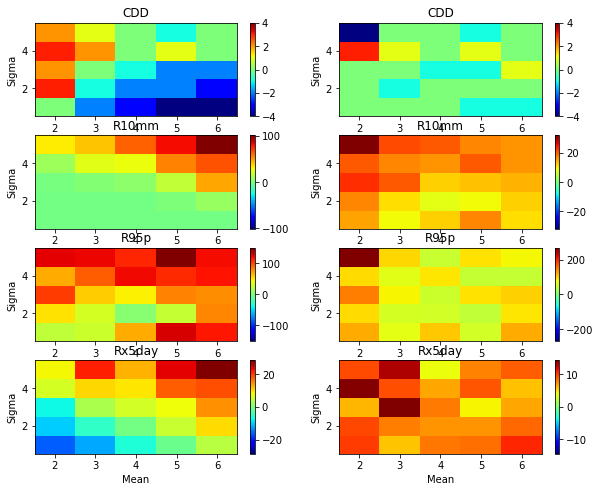

In [29]:
name='Rx5day'
plt.figure(figsize=(10,10))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)

for itr,ind_name in enumerate(['CDD','R10mm','R95p','Rx5day']):
    
    plt.subplot(5,2,itr*2 +1 )
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod-ind_obs)))
    plt.pcolor(xx,yy,ind_mod-ind_obs,vmin=-vmm,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    
    plt.subplot(5,2,itr*2 +2 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc-ind_obs)))
    plt.pcolor(xx,yy,ind_mbc-ind_obs,vmin=-vmm,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)


(6,)


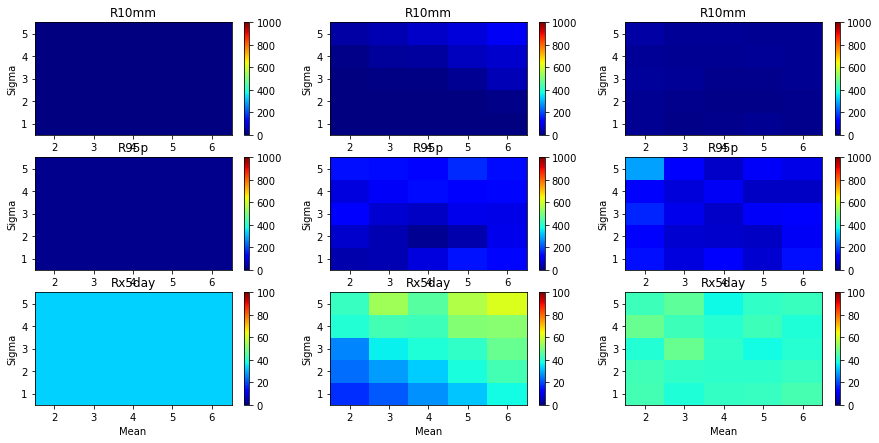

In [30]:
plt.figure(figsize=(15,12))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)
lim={}
lim['R10mm'] = 1000
lim['R95p'] = 1000
lim['Rx5day']=100
for itr,ind_name in enumerate(['R10mm','R95p','Rx5day']):
    
    plt.subplot(5,3,itr*3 +1 )
    
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_obs)))
    plt.pcolor(xx,yy,ind_obs,vmin=0,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])

    
    plt.subplot(5,3,itr*3 +2 )
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod)))
    plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.clim([0,lim[ind_name]])
    plt.title(ind_name)
    
    
    plt.subplot(5,3,itr*3 +3 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc)))
    plt.pcolor(xx,yy,ind_mbc,vmin=0,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])
    


# normal 

In [31]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model_sep['gamma'])/ncols))

# plt.figure(figsize=(15,45))
indices_obs ={}
indices_mod ={}
indices_mbc ={}
for name,func in zip(['CDD','R10mm','R95p','Rx5day'],[syn.CDD,syn.R10mm,syn.R95p,syn.Rx5day]):
    indices_obs[name]=[]
    indices_mod[name]=[]
    indices_mbc[name]=[]
    for itr,x in enumerate(data_model_sep['uniform']):

        bc_x = bias_corr_historical_normal(data_obs_normal,x)
#         print(func)
        try:
            indices_mbc[name].append(func(bc_x))
        except:
            bc_x[np.isinf(bc_x)]=np.nan
            indices_mbc[name].append(func(bc_x))
        indices_mod[name].append(func(x))
        indices_obs[name].append(func(data_obs_normal))
    

[11.49917527]
[4.36148323]
[10.90575116]
[11.92048592]
[6.61032107]
[10.90575116]
[12.64311846]
[8.79367095]
[10.90575116]
[12.36504946]
[10.95228254]
[10.90575116]
[11.68886702]
[12.91095572]
[10.90575116]
[11.43478421]
[5.3479323]
[10.90575116]
[11.19298003]
[7.86166076]
[10.90575116]
[11.63688626]
[9.46465525]
[10.90575116]
[12.23109913]
[11.82871896]
[10.90575116]
[12.70316411]
[13.75396434]
[10.90575116]
[11.06081867]
[5.99661882]
[10.90575116]
[11.62306847]
[8.65278053]
[10.90575116]
[11.29230777]
[10.86412103]
[10.90575116]
[11.80025593]
[13.06404317]
[10.90575116]
[12.06654228]
[15.01416085]
[10.90575116]
[11.64540234]
[6.78501774]
[10.90575116]
[11.71232294]
[9.20304344]
[10.90575116]
[11.14923176]
[12.50378613]
[10.90575116]
[11.9024817]
[14.66964005]
[10.90575116]
[12.21330475]
[16.68685307]
[10.90575116]
[11.69529118]
[7.75529588]
[10.90575116]
[11.51157699]
[9.88500031]
[10.90575116]
[11.66429621]
[13.898796]
[10.90575116]
[11.82166461]
[16.1617641]
[10.90575116]
[11.57457

(6,)


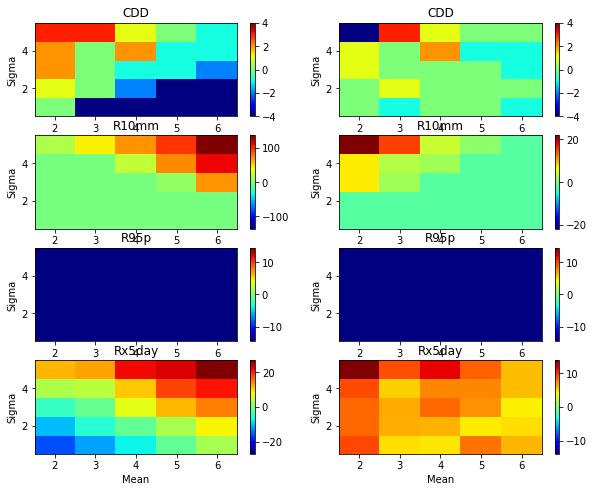

In [32]:
name='Rx5day'
plt.figure(figsize=(10,10))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)

for itr,ind_name in enumerate(['CDD','R10mm','R95p','Rx5day']):
    
    plt.subplot(5,2,itr*2 +1 )
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod-ind_obs)))
    plt.pcolor(xx,yy,ind_mod-ind_obs,vmin=-vmm,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    
    plt.subplot(5,2,itr*2 +2 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc-ind_obs)))
    plt.pcolor(xx,yy,ind_mbc-ind_obs,vmin=-vmm,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)


(6,)


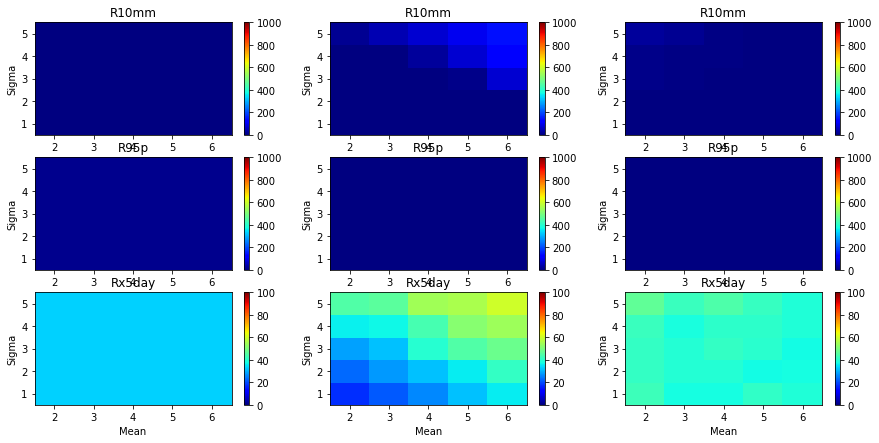

In [33]:
plt.figure(figsize=(15,12))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)
lim={}
lim['R10mm'] = 1000
lim['R95p'] = 1000
lim['Rx5day']=100
for itr,ind_name in enumerate(['R10mm','R95p','Rx5day']):
    
    plt.subplot(5,3,itr*3 +1 )
    
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_obs)))
    plt.pcolor(xx,yy,ind_obs,vmin=0,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])

    
    plt.subplot(5,3,itr*3 +2 )
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod)))
    plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.clim([0,lim[ind_name]])
    plt.title(ind_name)
    
    
    plt.subplot(5,3,itr*3 +3 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc)))
    plt.pcolor(xx,yy,ind_mbc,vmin=0,vmax=vmm,cmap='jet')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])
    


In [34]:
indices_obs[name]

[33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981,
 33.01188865259981]

In [35]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model_sep['gamma'])/ncols))

# plt.figure(figsize=(15,45))
indices_obs ={}
indices_mod ={}
indices_mbc ={}
for name,func in zip(['CDD','R10mm','R95p','Rx5day'],[syn.CDD,syn.R10mm,syn.R95p,syn.Rx5day]):
    indices_obs[name]=[]
    indices_mod[name]=[]
    indices_mbc[name]=[]
    for itr,x in enumerate(data_model_sep['normal']):

        bc_x = bias_corr_historical_gamma_zeros(data_obs_gamma,x)

        indices_mbc[name].append(func(bc_x))
        indices_mod[name].append(func(x))
        indices_obs[name].append(func(data_obs_gamma))
    

[9.57135928]
[4.09214505]
[10.70329283]
[9.85861241]
[6.1393494]
[10.70329283]
[9.2114577]
[7.77101837]
[10.70329283]
[9.01970497]
[10.67076551]
[10.70329283]
[8.86106619]
[12.92015968]
[10.70329283]
[9.92408412]
[5.10240232]
[10.70329283]
[9.84195777]
[7.26163472]
[10.70329283]
[9.9297764]
[8.89422385]
[10.70329283]
[9.40362008]
[11.90289077]
[10.70329283]
[9.19027517]
[14.50790755]
[10.70329283]
[10.10476579]
[5.96878405]
[10.70329283]
[9.93470422]
[8.58309925]
[10.70329283]
[10.81071659]
[10.69877957]
[10.70329283]
[10.02282271]
[12.22768094]
[10.70329283]
[9.46937986]
[14.75787083]
[10.70329283]
[10.49885804]
[6.80009456]
[10.70329283]
[9.47675421]
[9.47520674]
[10.70329283]
[10.04860046]
[11.3349532]
[10.70329283]
[10.94033626]
[12.86992857]
[10.70329283]
[9.53586849]
[16.20022385]
[10.70329283]
[10.06973966]
[7.77291331]
[10.70329283]
[9.9255108]
[10.09639479]
[10.70329283]
[9.37364339]
[12.40645018]
[10.70329283]
[10.34489787]
[13.6658038]
[10.70329283]
[10.60470443]
[16.5614374

(6,)


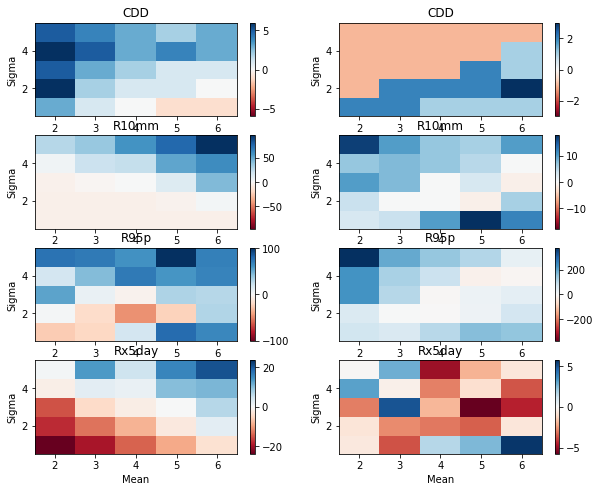

In [36]:
name='Rx5day'
plt.figure(figsize=(10,10))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)

for itr,ind_name in enumerate(['CDD','R10mm','R95p','Rx5day']):
    
    plt.subplot(5,2,itr*2 +1 )
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod-ind_obs)))
    plt.pcolor(xx,yy,ind_mod-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    
    plt.subplot(5,2,itr*2 +2 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc-ind_obs)))
    plt.pcolor(xx,yy,ind_mbc-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)


(6,)


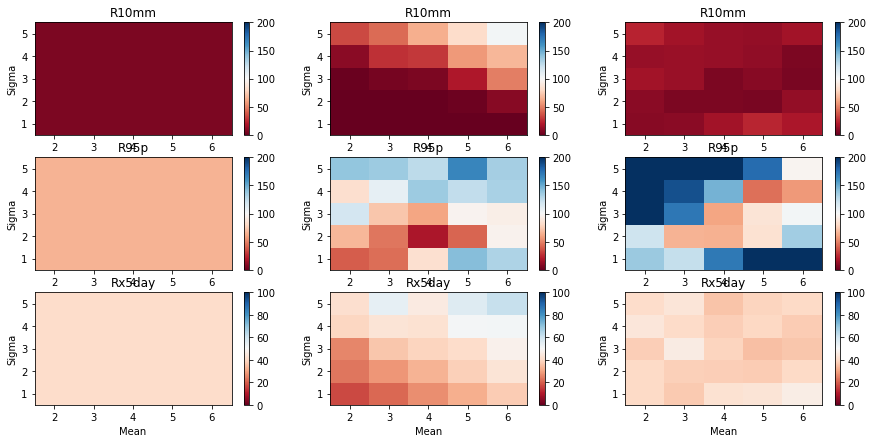

In [37]:
plt.figure(figsize=(15,12))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)
lim={}
lim['R10mm'] = 200
lim['R95p'] = 200
lim['Rx5day']=100
for itr,ind_name in enumerate(['R10mm','R95p','Rx5day']):
    
    plt.subplot(5,3,itr*3 +1 )
    
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_obs)))
    plt.pcolor(xx,yy,ind_obs,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])

    
    plt.subplot(5,3,itr*3 +2 )
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod)))
    plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.clim([0,lim[ind_name]])
    plt.title(ind_name)
    
    
    plt.subplot(5,3,itr*3 +3 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc)))
    plt.pcolor(xx,yy,ind_mbc,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])
    


In [38]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model_sep['gamma'])/ncols))

# plt.figure(figsize=(15,45))
indices_obs ={}
indices_mod ={}
indices_mbc ={}
for name,func in zip(['CDD','R10mm','R95p','Rx5day'],[syn.CDD,syn.R10mm,syn.R95p,syn.Rx5day]):
    indices_obs[name]=[]
    indices_mod[name]=[]
    indices_mbc[name]=[]
    for itr,x in enumerate(data_model_sep['normal']):

        bc_x = bias_corr_historical_gamma_zeros(data_obs_gamma,x)

        indices_mbc[name].append(func(bc_x))
        indices_mod[name].append(func(x))
        indices_obs[name].append(func(data_obs_gamma))
    

[9.57135928]
[4.09214505]
[10.70329283]
[9.85861241]
[6.1393494]
[10.70329283]
[9.2114577]
[7.77101837]
[10.70329283]
[9.01970497]
[10.67076551]
[10.70329283]
[8.86106619]
[12.92015968]
[10.70329283]
[9.92408412]
[5.10240232]
[10.70329283]
[9.84195777]
[7.26163472]
[10.70329283]
[9.9297764]
[8.89422385]
[10.70329283]
[9.40362008]
[11.90289077]
[10.70329283]
[9.19027517]
[14.50790755]
[10.70329283]
[10.10476579]
[5.96878405]
[10.70329283]
[9.93470422]
[8.58309925]
[10.70329283]
[10.81071659]
[10.69877957]
[10.70329283]
[10.02282271]
[12.22768094]
[10.70329283]
[9.46937986]
[14.75787083]
[10.70329283]
[10.49885804]
[6.80009456]
[10.70329283]
[9.47675421]
[9.47520674]
[10.70329283]
[10.04860046]
[11.3349532]
[10.70329283]
[10.94033626]
[12.86992857]
[10.70329283]
[9.53586849]
[16.20022385]
[10.70329283]
[10.06973966]
[7.77291331]
[10.70329283]
[9.9255108]
[10.09639479]
[10.70329283]
[9.37364339]
[12.40645018]
[10.70329283]
[10.34489787]
[13.6658038]
[10.70329283]
[10.60470443]
[16.5614374

(6,)


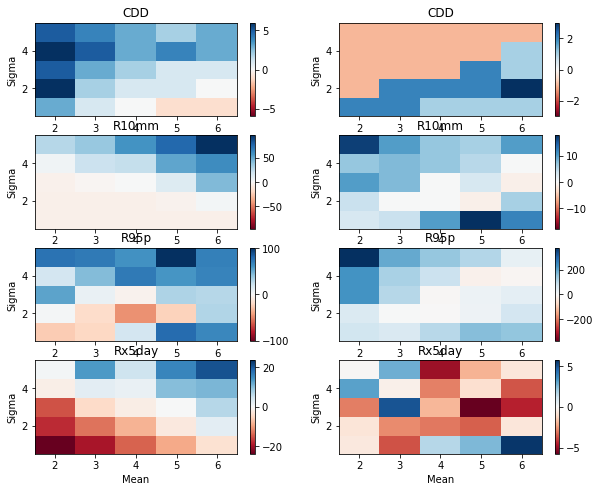

In [39]:
name='Rx5day'
plt.figure(figsize=(10,10))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)

for itr,ind_name in enumerate(['CDD','R10mm','R95p','Rx5day']):
    
    plt.subplot(5,2,itr*2 +1 )
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod-ind_obs)))
    plt.pcolor(xx,yy,ind_mod-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    
    plt.subplot(5,2,itr*2 +2 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc-ind_obs)))
    plt.pcolor(xx,yy,ind_mbc-ind_obs,vmin=-vmm,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)


(6,)


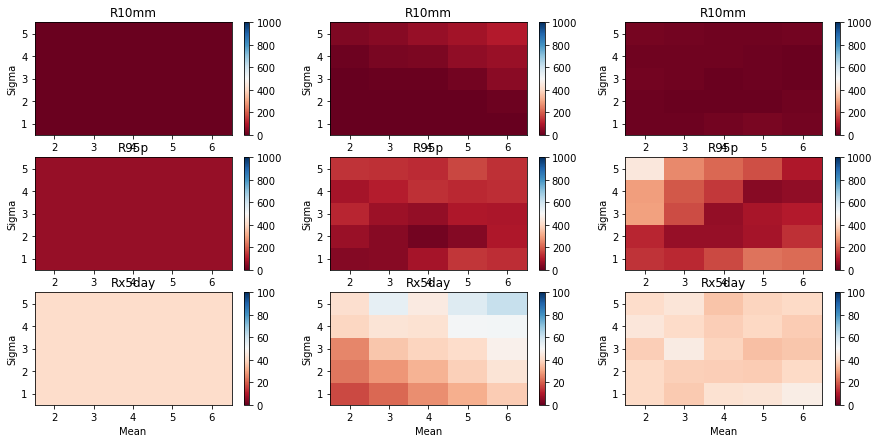

In [40]:
plt.figure(figsize=(15,12))

mumu =  uu.cen_to_box(np.arange(2,6.1,1))
sigsig = uu.cen_to_box(np.arange(1,5.1,1))
print(mumu.shape)
xx,yy=np.meshgrid(mumu,sigsig)
lim={}
lim['R10mm'] = 1000
lim['R95p'] = 1000
lim['Rx5day']=100
for itr,ind_name in enumerate(['R10mm','R95p','Rx5day']):
    
    plt.subplot(5,3,itr*3 +1 )
    
    ind_obs=np.array(indices_obs[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_obs)))
    plt.pcolor(xx,yy,ind_obs,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])

    
    plt.subplot(5,3,itr*3 +2 )
    ind_mod=np.array(indices_mod[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mod)))
    plt.pcolor(xx,yy,ind_mod,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.clim([0,lim[ind_name]])
    plt.title(ind_name)
    
    
    plt.subplot(5,3,itr*3 +3 )
    ind_mbc=np.array(indices_mbc[ind_name]).reshape((5,5),order='F')
    vmm = np.max(np.abs((ind_mbc)))
    plt.pcolor(xx,yy,ind_mbc,vmin=0,vmax=vmm,cmap='RdBu')
    plt.xlabel('Mean')
    plt.ylabel('Sigma')
    plt.colorbar()
    plt.title(ind_name)
    plt.clim([0,lim[ind_name]])
    


In [41]:
ncols = 3 # int(np.ceil(np.sqrt(len(data_model))))
nrows= int(np.ceil(len(data_model)/ncols))
print(nrows,ncols,len(data_model))
plt.figure(figsize=(15,45))
for itr,x in enumerate(data_model):
    
    ax=plt.subplot(nrows,ncols,itr+1)
    bc_x=bias_corr_historical_gamma_zeros(data_obs_gamma,x)
    plt.hist(bc_x,alpha=0.6)
    plt.hist(x,alpha=0.6)
plt.suptitle('Obs-N(4,3)')


0 3 0


Text(0.5, 0.98, 'Obs-N(4,3)')

<Figure size 1080x3240 with 0 Axes>

In [42]:
nrows = int(np.floor(np.sqrt(len(data_model['uniform']))))
ncols= int(np.round(len(data_model['uniform'])/nrows))

plt.figure(figsize=(15,15))
for itr,x in enumerate(data_model['uniform']):
    #     x=data_model['gamma'][0]
    ax=plt.subplot(nrows,ncols,itr+1)
    bc_x=bias_corr_historical_normal(dat_obs_gamma,x)
    qqplot(x,dat_obs_gamma, c='r', alpha=0.5, edgecolor='k',ax=ax)
    qqplot(bc_x,dat_obs_gamma,  c='g', alpha=0.5, edgecolor='k',ax=ax)

    plt.ylim([0,30])
    plt.xlim([0,30])
    # plt.xlabel('mm/day')
    plt.ylabel('Observed data')
    plt.legend(['model','QM_model'])
    plt.plot([0,60],[0,60])
    ax.set_aspect('equal')



TypeError: list indices must be integers or slices, not str

In [ ]:
nrows = int(np.floor(np.sqrt(len(data_model['normal']))))
ncols= int(np.round(len(data_model['normal'])/nrows))

plt.figure(figsize=(15,15))
for itr,x in enumerate(data_model['normal']):
    #     x=data_model['gamma'][0]
    ax=plt.subplot(nrows,ncols,itr+1)
    bc_x=bias_corr_historical_normal(dat_obs_gamma,x)
    qqplot(x,dat_obs_gamma, c='r', alpha=0.5, edgecolor='k',ax=ax)
    qqplot(bc_x,dat_obs_gamma,  c='g', alpha=0.5, edgecolor='k',ax=ax)

    plt.ylim([0,30])
    plt.xlim([0,30])
    # plt.xlabel('mm/day')
    plt.ylabel('Observed data')
    plt.legend(['model','QM_model'])
    plt.plot([0,60],[0,60])
    ax.set_aspect('equal')



### Gamma

Mean and variance
The mean of gamma distribution is given by the product of its shape and scale parameters: \
$ {\displaystyle \mu =k\theta =\alpha /\beta }{\displaystyle \mu =k\theta =\alpha /\beta } $ 

The variance is: \
$ {\displaystyle \sigma ^{2}=k\theta ^{2}=\alpha /\beta ^{2}}{\displaystyle \sigma ^{2}=k\theta ^{2}=\alpha /\beta ^{2}} $

In [ ]:

theta = sigma *sigma / mu
k= mu/theta

data = scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=10000)
plt.hist(data)
plt.figure()
x = np.linspace(0,20,200)
fitted_data = scipy.stats.gamma.pdf(x, a=k,loc=0,scale=theta)
# fita,fitloc,fitscale = scipy.stats.gamma.fit(data,floc=0,f0=3)
# plt.hist(data)
plt.plot(x,fitted_data)

print("Mean:", np.mean(data))
print("Mean_th:",k * theta)

print("Sig:", np.std(data))
print("Sig_th:",np.sqrt(k * theta**2))

### Normal

In [ ]:
data = scipy.stats.norm.rvs(loc=mu,scale=sigma, size=10000)
x = np.linspace(0,20,200)
fitted_data = scipy.stats.norm.pdf(x, loc=mu,scale=sigma)
plt.plot(x,fitted_data)

print("Mean:", np.mean(data))
print("Sig:", np.std(data))


### Uniform

$ Mean	{\displaystyle {\tfrac {1}{2}}(a+b)}{\tfrac {1}{2}}(a+b) $ \
$ Median	{\displaystyle {\tfrac {1}{2}}(a+b)}{\tfrac {1}{2}}(a+b) $ \
$ Mode	any value in {\displaystyle (a,b)}(a,b) $ \
$ Variance	{\displaystyle {\tfrac {1}{12}}(b-a)^{2}}{\tfrac {1}{12}}(b-a)^{2} $ \

In [ ]:
loc = mu - np.sqrt(3) * sigma
scale = 2 * np.sqrt(3) * sigma 
data = scipy.stats.uniform.rvs(loc=loc,scale=scale, size=10000)
x = np.linspace(0,20,200)
fitted_data = scipy.stats.uniform.pdf(x, loc=mu,scale=sigma)
plt.plot(x,fitted_data)

print("Mean:", np.mean(data))
print("Sig:", np.std(data))

## observation

### Normal

### Gamma

Mean: 4.544206640411998
Mean_th: 4.5
Sig: 3.7276850192714943
Sig_th: 3.6742346141747673


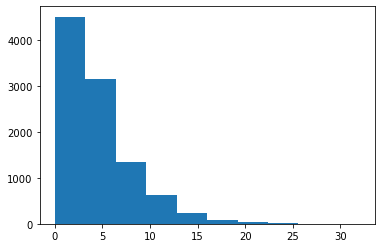

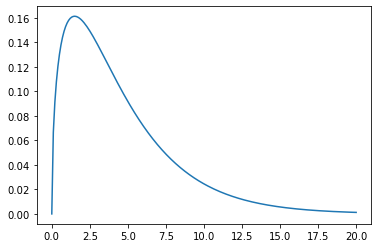

In [39]:
k= 1.5
theta = 3

data = scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=10000)
plt.hist(data)
plt.figure()
x = np.linspace(0,20,200)
fitted_data = scipy.stats.gamma.pdf(x, a=k,loc=0,scale=theta)
# fita,fitloc,fitscale = scipy.stats.gamma.fit(data,floc=0,f0=3)
# plt.hist(data)
plt.plot(x,fitted_data)

print("Mean:", np.mean(data))
print("Mean_th:",k * theta)

print("Sig:", np.std(data))
print("Sig_th:",np.sqrt(k * theta**2))

In [38]:
import scipy
from scipy.stats import gamma


def bias_corr_historical_normal(data_grid_obs,data_grid_hist):


    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[np.isnan(var_data_obs)]=np.nanmean(var_data_obs)
    var_data_hist[np.isnan(var_data_hist)]=np.nanmean(var_data_hist)

    bias_corr=np.zeros(var_data_hist.shape[0]);


    mu,sig = scipy.stats.norm.fit(var_data_hist)

    cdf = scipy.stats.norm.cdf(data_grid_hist,loc=mu,scale=sig)

    omu,osig = scipy.stats.norm.fit(var_data_obs)

    bias_corr=scipy.stats.norm.ppf(cdf,loc=omu,scale=osig)

    return bias_corr



import scipy
from scipy.stats import gamma


def bias_corr_historical_gamma_zeros(data_grid_obs,data_grid_hist):
    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[var_data_obs<0]=0
    var_data_hist[var_data_hist<0]=0

    var_data_obs[np.isnan(var_data_obs)]=0
    var_data_hist[np.isnan(var_data_hist)]=0

    bias_corr=np.zeros(var_data_hist.shape[0]);

    data=var_data_hist
    data_non_zeros=(data[data!=0])
    count_zeros=(data[data==0].shape[0])
    count_total=(data.shape[0])
    p_zeros=count_zeros/count_total
    fita,fitloc,fitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)

    cdf= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(var_data_hist, a=fita,loc=fitloc,scale=fitscale)

    data=var_data_obs
    data_non_zeros=(data[data!=0])
    count_zeros=(data[data==0].shape[0])
    count_total=(data.shape[0])
    p_zeros_imd=count_zeros/count_total
    ofita,ofitloc,ofitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)

    for iter in range(cdf.shape[0]):
        cdfi=cdf[iter]
    if cdfi<=p_zeros_imd:
        bias_corr[iter]=0
    else:
        z=(cdfi-p_zeros_imd)/(1-p_zeros_imd)
        bias_corr[iter]=scipy.stats.gamma.ppf(z, a=ofita,loc=ofitloc,scale=ofitscale)

    return bias_corr

# Other

## Pdfs


3 0 18.237529233525212


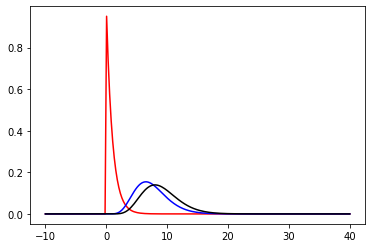

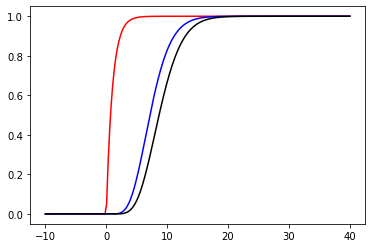

In [24]:
# gamma  k= 2 theta =2

data = scipy.stats.gamma.rvs(3, loc=10,scale=15, size=10000)
fita,fitloc,fitscale = scipy.stats.gamma.fit(data,floc=0,f0=3)


print(fita,fitloc,fitscale )

x = np.linspace(-10,40,200)
fitted_datac = scipy.stats.gamma.cdf(x, a=1,loc=0,scale=1)
fitted_data = scipy.stats.gamma.pdf(x, a=1,loc=0,scale=1)

fitted_data1c = scipy.stats.gamma.cdf(x, a=7.5,loc=0,scale=1)
fitted_data1 = scipy.stats.gamma.pdf(x, a=7.5,loc=0,scale=1)

fitted_data2c = scipy.stats.gamma.cdf(x, a=9,loc=0,scale=1)
fitted_data2 = scipy.stats.gamma.pdf(x, a=9,loc=0,scale=1)

# print(scipy.stats.gamma.ppf([0.2,0.5,0.8], a=1,loc=0,scale=2))
# print(scipy.stats.gamma.ppf([0.2,0.5,0.8], a=1,loc=10,scale=2))
# print(scipy.stats.gamma.ppf([0.2,0.5,0.8], a=7.5,loc=0,scale=1))
# print(scipy.stats.gamma.ppf([0.2,0.5,0.8], a=9,loc=0,scale=0.5))

plt.plot(x,fitted_data,'r-')
plt.plot(x,fitted_data1,'b-')
plt.plot(x,fitted_data2,'k-')
plt.figure()
plt.plot(x,fitted_datac,'r-')
plt.plot(x,fitted_data1c,'b-')
plt.plot(x,fitted_data2c,'k-')





<ipython-input-31-02aeae51bc3c>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-31-02aeae51bc3c>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)
<ipython-input-31-02aeae51bc3c>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

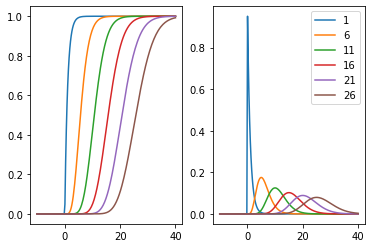

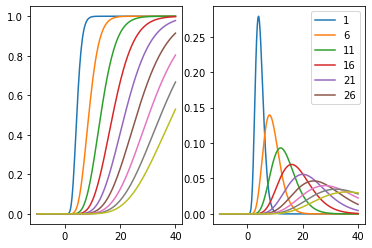

In [31]:
# x = np.linspace(-10,40,200)

for a in range(1,30,5):
    fitted_datac = scipy.stats.gamma.cdf(x, a=a,loc=0,scale=1)
    x = np.linspace(-10,40,200)
    plt.subplot(1,2,1)
    plt.plot(x,fitted_datac,)
    
    fitted_data = scipy.stats.gamma.pdf(x, a=a,loc=0,scale=1)
    plt.subplot(1,2,2)
    plt.plot(x,fitted_data,)
plt.legend(range(1,30,5))


plt.figure()
for a in np.arange(0.5,5,0.5):
    fitted_datac = scipy.stats.gamma.cdf(x, a=9,loc=0,scale=a)
    x = np.linspace(-10,40,200)
    plt.subplot(1,2,1)
    plt.plot(x,fitted_datac,)
    
    fitted_data = scipy.stats.gamma.pdf(x, a=9,loc=0,scale=a)
    plt.subplot(1,2,2)
    plt.plot(x,fitted_data,)
plt.legend(range(1,30,5))